Integrantes:
- Esteban Avilés Lino
- Carlos Zegarra Sialer
- Alexys Caytano 

# 1. Introducción

## 1.1. Descripción del proyecto

## 1.2. Descripción del dataset

# 2. Importar librerías

# 3. Carga de los datos y descripción general

## 3.1. Cargar el dataset

Se tienen 18 arhivos .mat, 9 de ellos sirven para el entrenamiento del modelo y los otros 9 para el testeo del modelo, por lo que se tendrán en arreglos distintos.

In [1]:
import os
from scipy.io import loadmat
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, "data")
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test")
train_files = os.listdir(TRAIN_DATA_PATH)
train_files.sort()
test_files = os.listdir(TEST_DATA_PATH)
test_files.sort()
train_mat_files = []
for file in train_files:
    if file.endswith(".mat"):
        train_mat_files.append(loadmat(os.path.join(TRAIN_DATA_PATH, file)))
test_mat_files = []
for file in test_files:
    if file.endswith(".mat"):
        test_mat_files.append(loadmat(os.path.join(TEST_DATA_PATH, file)))
print(f"Se cargaron {len(train_mat_files)} archivos .mat de entrenamiento")
print(f"Se cargaron {len(test_mat_files)} archivos .mat de testeo")

Se cargaron 9 archivos .mat de entrenamiento
Se cargaron 9 archivos .mat de testeo


## 3.2. Inspección preliminar

El tipo de dato que se extraen de los archivos .mat son diccionarios.

In [2]:
train_example = train_mat_files[0]
type(train_example)

dict

Cada diccionario contiene metadata relacionada al archivo importaddo, en este caso solo nos importa `data`.

In [3]:
train_example.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

El tipo de dato que contiene la llave `data` es un array de NumPy.

In [4]:
data_example = train_example["data"]
type(data_example)

numpy.ndarray

Este array tiene una forma de 1x9. Esto está relacionado al número de sesiones que tiene cada archivo.

In [5]:
data_example.shape

(1, 9)

Los primeros 3 bloques contienen sesiones de electrooculograma (EOG). El tipo de dato que contiene cada sesión es un array de NumPy.

In [6]:
example = data_example[0, 0]
type(example)

numpy.ndarray

La forma del array es de 1x1.

In [7]:
example.shape

(1, 1)

Si entramos al único elemento del array, vemos que el tipo de dato que contiene es un NumPy void.

In [8]:
aux = example[0, 0]
type(aux)

numpy.void

Los tipos de dato que contiene están relacionados al tipo de información que brinda cada elemento. Estos son:
- `X`: señales EEG y EOG en forma de matriz
- `trial`: número de muestra en el que inicia cada trial.
- `y`: vector de clases para cada trial.
- `fs`: frecuencia de muestreo.
- `classes`: movimiento imaginado para cada etiqueta.
- `artifacts`: vector que menciona si la señal contiene artefactos de EOG
- `gender`: género del voluntario.
- `age`: edad del voluntario.

In [9]:
aux.dtype

dtype([('X', 'O'), ('trial', 'O'), ('y', 'O'), ('fs', 'O'), ('classes', 'O'), ('artifacts', 'O'), ('gender', 'O'), ('age', 'O')])

Los bloques de EOG solo contienen datos de interés en `X`, ya que este contiene las señales EEG y EOG de los bloques correspondientes.

In [10]:
aux["X"].shape, aux["fs"][0][0]

((29683, 25), 250)

Ahora veamos un ejemplo de bloques de imaginación motora. Nuevamente, el tipo de dato que contiene es un array de NumPy.

In [11]:
example = data_example[0, 3]
type(example)

numpy.ndarray

La forma del array es 1x1.

In [12]:
example.shape

(1, 1)

Si entramos al único elemento del array, vemos que el tipo de dato que contiene es un NumPy void.

In [13]:
aux = example[0, 0]
type(aux)

numpy.void

Los tipos de datos recogidos son los mismos que los observados en los bloques de EOG.

In [14]:
aux.dtype

dtype([('X', 'O'), ('trial', 'O'), ('y', 'O'), ('fs', 'O'), ('classes', 'O'), ('artifacts', 'O'), ('gender', 'O'), ('age', 'O')])

En los bloques de EEG donde se realizó la imaginación motora se tiene más información de interés, estos son: `X`, `trial`, `y`, `artifacts`.

In [15]:
import numpy as np
aux["X"].shape, aux["trial"].shape, np.unique(aux["y"]), np.unique(aux["artifacts"])

((96735, 25),
 (48, 1),
 array([1, 2, 3, 4], dtype=uint8),
 array([0, 1], dtype=uint8))

## 3.3. Preparación de los datos

Se generaron funciones para la extracción de los datos de cada uno de los sujetos. Es importante notar que el sujeto 04 solo contiene un bloque de EOG, por lo que hay funciones específicas para este sujeto. Por otro lado, no se extrae la información de los artefactos pues estos se eliminan con los filtros aplicados posteriormente.

In [16]:
def extract_eeg(data_dict):
    data = data_dict["data"]
    eeg = []
    for i in range(3, 9):
        eeg.append(data[0, i][0, 0]["X"])
    return np.array(eeg, dtype=object)

def extract_eeg_04(data_dict):
    data = data_dict["data"]
    eeg = []
    for i in range(1, 7):
        eeg.append(data[0, i][0, 0]["X"])
    return np.array(eeg, dtype=object)

def extract_trial(data_dict):
    data = data_dict["data"]
    trial = []
    for i in range(3, 9):
        trial.append(data[0, i][0, 0]["trial"])
    return np.array(trial, dtype=object)

def extract_trial_04(data_dict):
    data = data_dict["data"]
    trial = []
    for i in range(1, 7):
        trial.append(data[0, i][0, 0]["trial"])
    return np.array(trial, dtype=object)

def extract_y(data_dict):
    data = data_dict["data"]
    y = []
    for i in range(3, 9):
        y.append(data[0, i][0, 0]["y"])
    return np.array(y, dtype=object)

def extract_y_04(data_dict):
    data = data_dict["data"]
    y = []
    for i in range(1, 7):
        y.append(data[0, i][0, 0]["y"])
    return np.array(y, dtype=object)

Se procede a la extracción de la información de cada uno de los sujetos.

### 3.3.1. Sujeto 1

In [17]:
eeg_a01_train = extract_eeg(train_mat_files[0])
trial_a01_train = extract_trial(train_mat_files[0])
y_a01_train = extract_y(train_mat_files[0])

eeg_a01_test = extract_eeg(test_mat_files[0])
trial_a01_test = extract_trial(test_mat_files[0])
y_a01_test = extract_y(test_mat_files[0])

eeg_a01_train.shape, eeg_a01_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.2. Sujeto 2

In [18]:
eeg_a02_train = extract_eeg(train_mat_files[1])
trial_a02_train = extract_trial(train_mat_files[1])
y_a02_train = extract_y(train_mat_files[1])

eeg_a02_test = extract_eeg(test_mat_files[1])
trial_a02_test = extract_trial(test_mat_files[1])
y_a02_test = extract_y(test_mat_files[1])

eeg_a02_train.shape, eeg_a02_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.3. Sujeto 3

In [19]:
eeg_a03_train = extract_eeg(train_mat_files[2])
trial_a03_train = extract_trial(train_mat_files[2])
y_a03_train = extract_y(train_mat_files[2])

eeg_a03_test = extract_eeg(test_mat_files[2])
trial_a03_test = extract_trial(test_mat_files[2])
y_a03_test = extract_y(test_mat_files[2])

eeg_a03_train.shape, eeg_a03_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.4. Sujeto 4

In [20]:
eeg_a04_train = extract_eeg_04(train_mat_files[3])
trial_a04_train = extract_trial_04(train_mat_files[3])
y_a04_train = extract_y_04(train_mat_files[3])

eeg_a04_test = extract_eeg(test_mat_files[3])
trial_a04_test = extract_trial(test_mat_files[3])
y_a04_test = extract_y(test_mat_files[3])

eeg_a04_train.shape, eeg_a04_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.5. Sujeto 5

In [21]:
eeg_a05_train = extract_eeg(train_mat_files[4])
trial_a05_train = extract_trial(train_mat_files[4])
y_a05_train = extract_y(train_mat_files[4])

eeg_a05_test = extract_eeg(test_mat_files[4])
trial_a05_test = extract_trial(test_mat_files[4])
y_a05_test = extract_y(test_mat_files[4])

eeg_a05_train.shape, eeg_a05_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.6. Sujeto 6

In [22]:
eeg_a06_train = extract_eeg(train_mat_files[5])
trial_a06_train = extract_trial(train_mat_files[5])
y_a06_train = extract_y(train_mat_files[5])

eeg_a06_test = extract_eeg(test_mat_files[5])
trial_a06_test = extract_trial(test_mat_files[5])
y_a06_test = extract_y(test_mat_files[5])

eeg_a06_train.shape, eeg_a06_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.7. Sujeto 7

In [23]:
eeg_a07_train = extract_eeg(train_mat_files[6])
trial_a07_train = extract_trial(train_mat_files[6])
y_a07_train = extract_y(train_mat_files[6])

eeg_a07_test = extract_eeg(test_mat_files[6])
trial_a07_test = extract_trial(test_mat_files[6])
y_a07_test = extract_y(test_mat_files[6])

eeg_a07_train.shape, eeg_a07_test.shape, trial_a07_train.shape

((6, 96735, 25), (6, 96735, 25), (6, 48, 1))

### 3.3.8. Sujeto 8

In [24]:
eeg_a08_train = extract_eeg(train_mat_files[7])
trial_a08_train = extract_trial(train_mat_files[7])
y_a08_train = extract_y(train_mat_files[7])

eeg_a08_test = extract_eeg(test_mat_files[7])
trial_a08_test = extract_trial(test_mat_files[7])
y_a08_test = extract_y(test_mat_files[7])

eeg_a08_train.shape, eeg_a08_test.shape

((6, 96735, 25), (6, 96735, 25))

### 3.3.9. Sujeto 9

In [25]:
eeg_a09_train = extract_eeg(train_mat_files[8])
trial_a09_train = extract_trial(train_mat_files[8])
y_a09_train = extract_y(train_mat_files[8])

eeg_a09_test = extract_eeg(test_mat_files[8])
trial_a09_test = extract_trial(test_mat_files[8])
y_a09_test = extract_y(test_mat_files[8])

eeg_a09_train.shape, eeg_a09_test.shape

((6, 96735, 25), (6, 96735, 25))

## 3.4. Ejemplo de EEG crudo

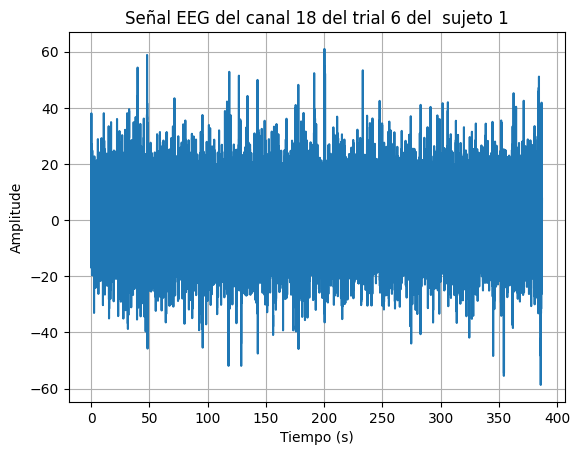

In [26]:
import matplotlib.pyplot as plt

trial = np.random.randint(0, 6)
chn = np.random.randint(0, 22)
sig = eeg_a01_train[trial, :, chn]
n = np.arange(0, len(sig))
t = n/250.0


plt.figure()
plt.plot(t, sig)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitude")
plt.title(f"Señal EEG del canal {chn+1} del trial {trial+1} del  sujeto 1")
plt.grid(True)
plt.show()

## 3.5. Ejemplo de FFT crudo

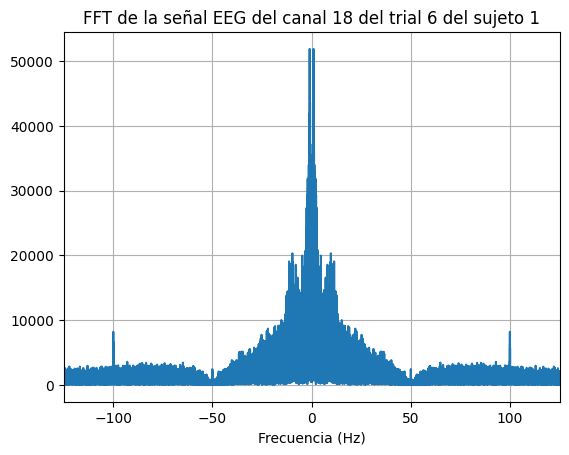

In [27]:
sig_fft = np.fft.fftshift(np.fft.fft(sig))

N = len(sig_fft)
fs = 250.0
w = 2*np.pi*np.arange(N)/N
w = np.fft.fftshift(w)
w = np.unwrap(w - 2*np.pi)
f = w*fs/(2*np.pi)

plt.figure(4)
plt.plot(f, np.abs(sig_fft))
plt.title(f"FFT de la señal EEG del canal {chn+1} del trial {trial+1} del sujeto 1")
plt.xlabel("Frecuencia (Hz)")
plt.grid(True)
plt.autoscale(enable=True, axis="x", tight=True)
plt.show()

# 4. Limpieza de datos y pre-procesamiento

## 4.1. Segmentación de datos

Se generaron funciones para la extraer los segmentos importantes de cada uno de los sujetos. Se hizo lo mismo para las etiquetas pues hay una etiqueta para cada segmento. Estos segmentos están definidos por el número de muestra donde inicia el `trial`, y la muestra anterior al inicio del siguiente `trial`. Por ello, se segmentará la data del EEG en 48 segmentos de diferentes tamaños.

In [28]:
def extract_segmented_eeg(eegs, trials):
    eeg_segmented = []
    for i, eeg in enumerate(eegs):
        for j, trial in enumerate(trials[i, :, :]):
            if j == len(trials[i, :, :]) - 1:
                sigs = eeg[trial[0]:, :]
            else:
                sigs = eeg[trial[0]:trials[i, j+1, :][0], :]
            eeg_segmented.append(sigs)
    return np.array(eeg_segmented, dtype=object)

def extract_labels(labels, trials):
    eeg_segmented = []
    for i, _ in enumerate(labels):
        for j, _ in enumerate(trials[i, :, :]):
            eeg_segmented.append(labels[i, j, 0])
    return np.array(eeg_segmented, dtype=object)

### 4.1.1. Sujeto 1

In [29]:
eeg_segmented_a01_train = extract_segmented_eeg(eeg_a01_train, trial_a01_train)
y_a01_train = extract_labels(y_a01_train, trial_a01_train)

eeg_segmented_a01_test = extract_segmented_eeg(eeg_a01_test, trial_a01_test)
y_a01_test = extract_labels(y_a01_test, trial_a01_test)

eeg_segmented_a01_train.shape, eeg_segmented_a01_test.shape, y_a01_train.shape, y_a01_test.shape

((288,), (288,), (288,), (288,))

### 4.1.2. Sujeto 2

In [30]:
eeg_segmented_a02_train = extract_segmented_eeg(eeg_a02_train, trial_a02_train)
y_a02_train = extract_labels(y_a02_train, trial_a02_train)

eeg_segmented_a02_test = extract_segmented_eeg(eeg_a02_test, trial_a02_test)
y_a02_test = extract_labels(y_a02_test, trial_a02_test)

eeg_segmented_a02_train.shape, eeg_segmented_a02_test.shape, y_a02_train.shape, y_a02_test.shape

((288,), (288,), (288,), (288,))

### 4.1.3. Sujeto 3

In [31]:
eeg_segmented_a03_train = extract_segmented_eeg(eeg_a03_train, trial_a03_train)
y_a03_train = extract_labels(y_a03_train, trial_a03_train)

eeg_segmented_a03_test = extract_segmented_eeg(eeg_a03_test, trial_a03_test)
y_a03_test = extract_labels(y_a03_test, trial_a03_test)

eeg_segmented_a03_train.shape, eeg_segmented_a03_test.shape, y_a03_train.shape, y_a03_test.shape

((288,), (288,), (288,), (288,))

### 4.1.4. Sujeto 4

In [32]:
eeg_segmented_a04_train = extract_segmented_eeg(eeg_a04_train, trial_a04_train)
y_a04_train = extract_labels(y_a04_train, trial_a04_train)

eeg_segmented_a04_test = extract_segmented_eeg(eeg_a04_test, trial_a04_test)
y_a04_test = extract_labels(y_a04_test, trial_a04_test)

eeg_segmented_a04_train.shape, eeg_segmented_a04_test.shape, y_a04_train.shape, y_a04_test.shape

((288,), (288,), (288,), (288,))

### 4.1.5. Sujeto 5

In [33]:
eeg_segmented_a05_train = extract_segmented_eeg(eeg_a05_train, trial_a05_train)
y_a05_train = extract_labels(y_a05_train, trial_a05_train)

eeg_segmented_a05_test = extract_segmented_eeg(eeg_a05_test, trial_a05_test)
y_a05_test = extract_labels(y_a05_test, trial_a05_test)

eeg_segmented_a05_train.shape, eeg_segmented_a05_test.shape, y_a05_train.shape, y_a05_test.shape

((288,), (288,), (288,), (288,))

### 4.1.6. Sujeto 6

In [34]:
eeg_segmented_a06_train = extract_segmented_eeg(eeg_a06_train, trial_a06_train)
y_a06_train = extract_labels(y_a06_train, trial_a06_train)

eeg_segmented_a06_test = extract_segmented_eeg(eeg_a06_test, trial_a06_test)
y_a06_test = extract_labels(y_a06_test, trial_a06_test)

eeg_segmented_a06_train.shape, eeg_segmented_a06_test.shape, y_a06_train.shape, y_a06_test.shape

((288,), (288,), (288,), (288,))

### 4.1.7. Sujeto 7

In [35]:
eeg_segmented_a07_train = extract_segmented_eeg(eeg_a07_train, trial_a07_train)
y_a07_train = extract_labels(y_a07_train, trial_a07_train)

eeg_segmented_a07_test = extract_segmented_eeg(eeg_a07_test, trial_a07_test)
y_a07_test = extract_labels(y_a07_test, trial_a07_test)

eeg_segmented_a07_train.shape, eeg_segmented_a07_test.shape, y_a07_train.shape, y_a07_test.shape

((288,), (288,), (288,), (288,))

### 4.1.8. Sujeto 8

In [36]:
eeg_segmented_a08_train = extract_segmented_eeg(eeg_a08_train, trial_a08_train)
y_a08_train = extract_labels(y_a08_train, trial_a08_train)

eeg_segmented_a08_test = extract_segmented_eeg(eeg_a08_test, trial_a08_test)
y_a08_test = extract_labels(y_a08_test, trial_a08_test)

eeg_segmented_a08_train.shape, eeg_segmented_a08_test.shape, y_a08_train.shape, y_a08_test.shape

((288,), (288,), (288,), (288,))

### 4.1.9. Sujeto 9

In [37]:
eeg_segmented_a09_train = extract_segmented_eeg(eeg_a09_train, trial_a09_train)
y_a09_train = extract_labels(y_a09_train, trial_a09_train)

eeg_segmented_a09_test = extract_segmented_eeg(eeg_a09_test, trial_a09_test)
y_a09_test = extract_labels(y_a09_test, trial_a09_test)

eeg_segmented_a09_train.shape, eeg_segmented_a09_test.shape, y_a09_train.shape, y_a09_test.shape

((288,), (288,), (288,), (288,))

## 4.2. Eliminamos segmentos innecesarios

Sabemos del dataset que solo nos interesa el rango de tiempo entre 3 y 6 segundos, por lo que en cada segmento nos quedamos únicamente con las muestras 750 a 1500. No obstante, es probable que parte de este tiempo no sea realmente el movimiento imaginado, de forma que para reducir el sesgo provocado por este rango de tiempo donde es posible que no se realice el movimiento imaginado se considerará el tiempo entre 3.5 segundos y 5.5 segundos. Así, se tomarán las muestras 875 a 1375. También nos quedaremos únicamente con los 22 canales de EEG y no los últimos 3 canales de EOG.

In [38]:
def extract_motor_imagery(segments, labels):
    new_segments = []
    new_labels = []
    for i, segment in enumerate(segments):
        new_segments.append(segment[875:1375, :])
        new_labels.append(labels[i])
    return np.array(new_segments), np.array(new_labels)

### 4.2.1. Sujeto 1

In [39]:
eeg_mi_a01_train, y_mi_a01_train = extract_motor_imagery(eeg_segmented_a01_train, y_a01_train)
eeg_mi_a01_test, y_mi_a01_test = extract_motor_imagery(eeg_segmented_a01_test, y_a01_test)
eeg_mi_a01_train.shape, eeg_mi_a01_test.shape, y_mi_a01_train.shape, y_mi_a01_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.2. Sujeto 2

In [40]:
eeg_mi_a02_train, y_mi_a02_train = extract_motor_imagery(eeg_segmented_a02_train, y_a02_train)
eeg_mi_a02_test, y_mi_a02_test = extract_motor_imagery(eeg_segmented_a02_test, y_a02_test)
eeg_mi_a02_train.shape, eeg_mi_a02_test.shape, y_mi_a02_train.shape, y_mi_a02_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.3. Sujeto 3

In [41]:
eeg_mi_a03_train, y_mi_a03_train = extract_motor_imagery(eeg_segmented_a03_train, y_a03_train)
eeg_mi_a03_test, y_mi_a03_test = extract_motor_imagery(eeg_segmented_a03_test, y_a03_test)
eeg_mi_a03_train.shape, eeg_mi_a03_test.shape, y_mi_a03_train.shape, y_mi_a03_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.4. Sujeto 4

In [42]:
eeg_mi_a04_train, y_mi_a04_train = extract_motor_imagery(eeg_segmented_a04_train, y_a04_train)
eeg_mi_a04_test, y_mi_a04_test = extract_motor_imagery(eeg_segmented_a04_test, y_a04_test)
eeg_mi_a04_train.shape, eeg_mi_a04_test.shape, y_mi_a04_train.shape, y_mi_a04_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.5. Sujeto 5

In [43]:
eeg_mi_a05_train, y_mi_a05_train = extract_motor_imagery(eeg_segmented_a05_train, y_a05_train)
eeg_mi_a05_test, y_mi_a05_test = extract_motor_imagery(eeg_segmented_a05_test, y_a05_test)
eeg_mi_a05_train.shape, eeg_mi_a05_test.shape, y_mi_a05_train.shape, y_mi_a05_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.6. Sujeto 6

In [44]:
eeg_mi_a06_train, y_mi_a06_train = extract_motor_imagery(eeg_segmented_a06_train, y_a06_train)
eeg_mi_a06_test, y_mi_a06_test = extract_motor_imagery(eeg_segmented_a06_test, y_a06_test)
eeg_mi_a06_train.shape, eeg_mi_a06_test.shape, y_mi_a06_train.shape, y_mi_a06_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.7. Sujeto 7

In [45]:
eeg_mi_a07_train, y_mi_a07_train = extract_motor_imagery(eeg_segmented_a07_train, y_a07_train)
eeg_mi_a07_test, y_mi_a07_test = extract_motor_imagery(eeg_segmented_a07_test, y_a07_test)
eeg_mi_a07_train.shape, eeg_mi_a07_test.shape, y_mi_a07_train.shape, y_mi_a07_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.8. Sujeto 8

In [46]:
eeg_mi_a08_train, y_mi_a08_train = extract_motor_imagery(eeg_segmented_a08_train, y_a08_train)
eeg_mi_a08_test, y_mi_a08_test = extract_motor_imagery(eeg_segmented_a08_test, y_a08_test)
eeg_mi_a08_train.shape, eeg_mi_a08_test.shape, y_mi_a08_train.shape, y_mi_a08_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

### 4.2.9. Sujeto 9

In [47]:
eeg_mi_a09_train, y_mi_a09_train = extract_motor_imagery(eeg_segmented_a09_train, y_a09_train)
eeg_mi_a09_test, y_mi_a09_test = extract_motor_imagery(eeg_segmented_a09_test, y_a09_test)
eeg_mi_a09_train.shape, eeg_mi_a09_test.shape, y_mi_a09_train.shape, y_mi_a09_test.shape

((288, 500, 25), (288, 500, 25), (288,), (288,))

## 4.3. Revisión señal

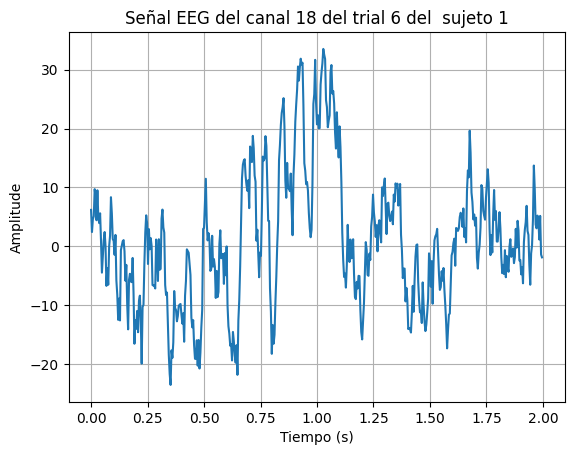

In [48]:
sig = eeg_mi_a01_train[trial, :, chn]
n = np.arange(0, len(sig))
t = n/250.0


plt.figure()
plt.plot(t, sig)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitude")
plt.title(f"Señal EEG del canal {chn+1} del trial {trial+1} del  sujeto 1")
plt.grid(True)
plt.show()

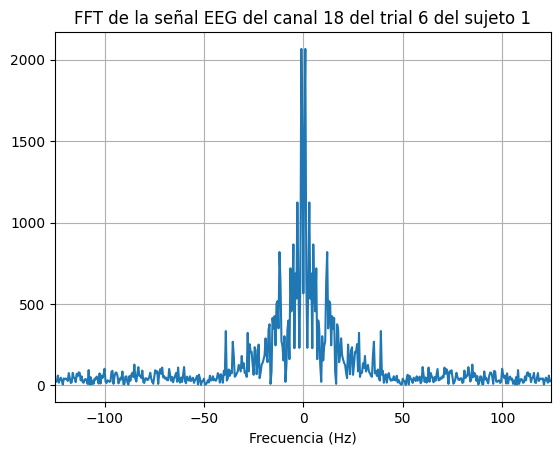

In [49]:
sig_fft = np.fft.fftshift(np.fft.fft(sig))

N = len(sig_fft)
w = 2*np.pi*np.arange(N)/N
w = np.fft.fftshift(w)
w = np.unwrap(w - 2*np.pi)
f = w*fs/(2*np.pi)

plt.figure(4)
plt.plot(f, np.abs(sig_fft))
plt.title(f"FFT de la señal EEG del canal {chn+1} del trial {trial+1} del sujeto 1")
plt.xlabel("Frecuencia (Hz)")
plt.grid(True)
plt.autoscale(enable=True, axis="x", tight=True)
plt.show()

## 4.3. Generación de epochs

Una manera sencilla de trabajar las señales de EEG es mediante una estructura de datos conocida como `Epochs`, los cuales permiten el filtrado de las señales y la decodificación espacial. Por ello, se procede a generar estas estructuras para cada trial. Para esto, se definió la frecuencia de muestro de estas señales en 250 Hz, se definieron los nombres de los canales, el tipo de canales, y los posibles eventos.

In [50]:
import mne
sampling_freq = 250
ch_names = [f"EEG{n:03}" for n in range(1, 23)] + [f"EOG{n:03}" for n in range(1, 4)]
ch_types = ["eeg"]*22 + ["eog"]*3
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
event_dict = dict(left_hand=1, right_hand=2, foot=3, tongue=4)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG001, EEG002, EEG003, EEG004, EEG005, EEG006, EEG007, EEG008, ...
 chs: 22 EEG, 3 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 25
 projs: []
 sfreq: 250.0 Hz
>


Se generaron funciones para construir las estructuras de datos `Epoch` para cada uno de los sujetos.

In [51]:
mne.set_log_level(False)
def epoch_generation(data, labels):
    events = np.column_stack((
        np.arange(0, data.shape[0]*500, 500),
        np.zeros(data.shape[0], dtype=int),
        labels.T
    ))
    epoch_data = mne.EpochsArray(
        np.swapaxes(data, 1, 2),
        info,
        events=events,
        event_id=event_dict,
        tmin=-1.0
    )
    return epoch_data

### 4.3.1. Sujeto 1

In [52]:
a01_train = epoch_generation(eeg_mi_a01_train, y_mi_a01_train)
a01_test = epoch_generation(eeg_mi_a01_test, y_mi_a01_test)

### 4.3.2. Sujeto 2

In [53]:
a02_train = epoch_generation(eeg_mi_a02_train, y_mi_a02_train)
a02_test = epoch_generation(eeg_mi_a02_test, y_mi_a02_test)

### 4.3.3. Sujeto 3

In [54]:
a03_train = epoch_generation(eeg_mi_a03_train, y_mi_a03_train)
a03_test = epoch_generation(eeg_mi_a03_test, y_mi_a03_test)

### 4.3.4. Sujeto 4

In [55]:
a04_train = epoch_generation(eeg_mi_a04_train, y_mi_a04_train)
a04_test = epoch_generation(eeg_mi_a04_test, y_mi_a04_test)

### 4.3.5. Sujeto 5

In [56]:
a05_train = epoch_generation(eeg_mi_a05_train, y_mi_a05_train)
a05_test = epoch_generation(eeg_mi_a05_test, y_mi_a05_test)

### 4.3.6. Sujeto 6

In [57]:
a06_train = epoch_generation(eeg_mi_a06_train, y_mi_a06_train)
a06_test = epoch_generation(eeg_mi_a06_test, y_mi_a06_test)

### 4.3.7. Sujeto 7

In [58]:
a07_train = epoch_generation(eeg_mi_a07_train, y_mi_a07_train)
a07_test = epoch_generation(eeg_mi_a07_test, y_mi_a07_test)

### 4.3.8. Sujeto 8

In [59]:
a08_train = epoch_generation(eeg_mi_a08_train, y_mi_a08_train)
a08_test = epoch_generation(eeg_mi_a08_test, y_mi_a08_test)

### 4.3.9. Sujeto 9

In [60]:
a09_train = epoch_generation(eeg_mi_a09_train, y_mi_a09_train)
a09_test = epoch_generation(eeg_mi_a09_test, y_mi_a09_test)

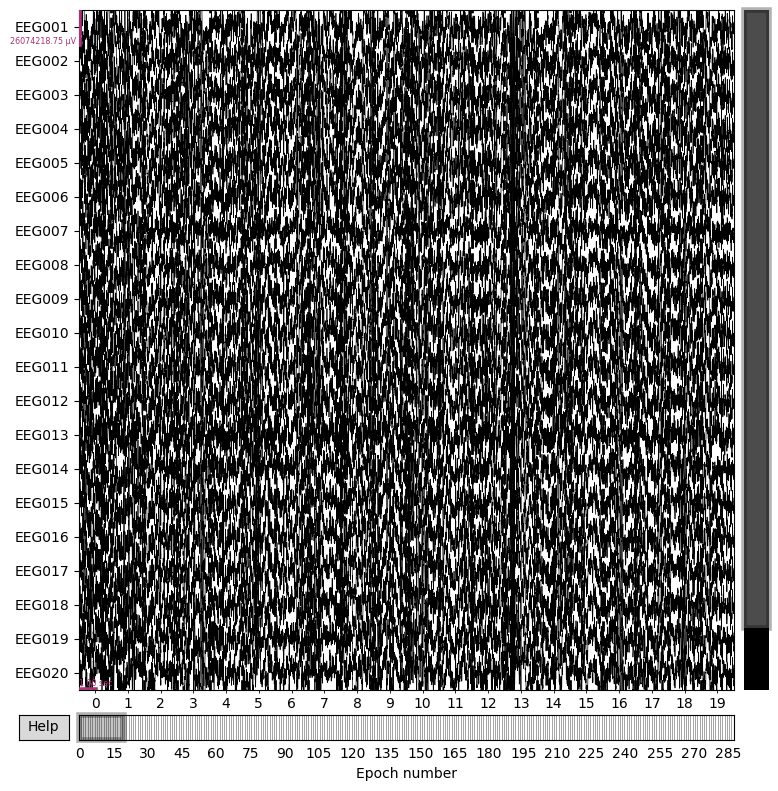

In [61]:
a01_train.plot(scalings="auto")
plt.show()

C:\Users\eavil\AppData\Local\Temp\ipykernel_35536\1309832796.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  a01_train.plot_psd(dB=False)
c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


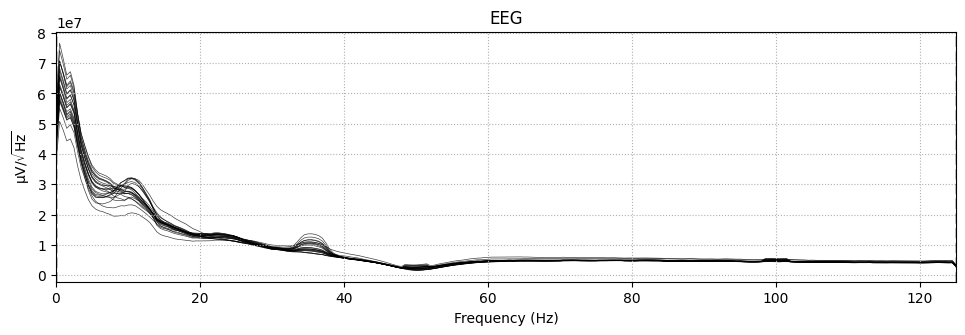

In [62]:
a01_train.plot_psd(dB=False)
plt.show()

# 5. Selección del modelo

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from mne.decoding import CSP
from mne.preprocessing import ICA

## 5.1. Uniform Filter Bank Common Spatial Pattern

In [112]:
# Uniform Filter Bank Common Spatial Pattern
class UFBCSP:

    def __init__(self, n_components, k, estimator):
        self.n_components = n_components
        self.k = k
        self.estimator = estimator
    
    def preprocess(self, data):
        new_data = data.copy().filter(1, 40, n_jobs=-1, method="iir")
        ica = ICA(n_components=0.95, random_state=42)
        ica.fit(new_data)
        eog_inds, scores = ica.find_bads_eog(new_data)
        ica.exclude = eog_inds
        epochs_clean = ica.apply(new_data.copy())
        epochs_clean = epochs_clean.pick_types(eeg=True)
        return epochs_clean

    def filter_bands(self, data):
        b1 = data.copy().filter(4, 8, n_jobs=-1, method="iir")
        b2 = data.copy().filter(8, 12, n_jobs=-1, method="iir")
        b3 = data.copy().filter(12, 16, n_jobs=-1, method="iir")
        b4 = data.copy().filter(16, 20, n_jobs=-1, method="iir")
        b5 = data.copy().filter(20, 24, n_jobs=-1, method="iir")
        b6 = data.copy().filter(24, 28, n_jobs=-1, method="iir")
        b7 = data.copy().filter(28, 32, n_jobs=-1, method="iir")
        b8 = data.copy().filter(32, 36, n_jobs=-1, method="iir")
        b9 = data.copy().filter(36, 40, n_jobs=-1, method="iir")
        bands = [b1, b2, b3, b4, b5, b6, b7, b8, b9]
        return bands
    
    def common_spatial_pattern(self, band):
        epochs = band.copy()
        labels = epochs.events[:, -1]
        epochs_data = epochs.get_data()
        csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
        csp_band = csp.fit(epochs_data, labels)
        features_band = csp_band.transform(epochs_data)
        return csp_band, features_band

    def fit(self, epoch_data, labels):

        self.data = self.preprocess(epoch_data)

        self.train_bands = self.filter_bands(self.data)

        self.csp1, self.x1 = self.common_spatial_pattern(self.train_bands[0])
        self.csp2, self.x2 = self.common_spatial_pattern(self.train_bands[1])
        self.csp3, self.x3 = self.common_spatial_pattern(self.train_bands[2])
        self.csp4, self.x4 = self.common_spatial_pattern(self.train_bands[3])
        self.csp5, self.x5 = self.common_spatial_pattern(self.train_bands[4])
        self.csp6, self.x6 = self.common_spatial_pattern(self.train_bands[5])
        self.csp7, self.x7 = self.common_spatial_pattern(self.train_bands[6])
        self.csp8, self.x8 = self.common_spatial_pattern(self.train_bands[7])
        self.csp9, self.x9 = self.common_spatial_pattern(self.train_bands[8])

        X_train = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6,
            self.x7,
            self.x8,
            self.x9
        ], axis=1)
        y_train = labels.astype("int")

        self.select = SelectKBest(mutual_info_classif, k=self.k).fit(X_train, y_train)
        X_train_select = X_train[:, self.select.get_support()]

        # self.ss = StandardScaler()
        # X_train_select = self.ss.fit_transform(X_train_select)

        # self.pca = PCA(n_components=0.95, random_state=42)
        # X_train_select = self.pca.fit_transform(X_train_select)

        self.estimator.fit(X_train_select, y_train)

        self.train_labels = y_train
        self.train_preds = self.estimator.predict(X_train_select)
    
    def predict(self, epoch_data):

        self.data = self.preprocess(epoch_data)

        self.test_bands = self.filter_bands(self.data)

        self.x1 = self.csp1.transform(self.test_bands[0].get_data())
        self.x2 = self.csp2.transform(self.test_bands[1].get_data())
        self.x3 = self.csp3.transform(self.test_bands[2].get_data())
        self.x4 = self.csp4.transform(self.test_bands[3].get_data())
        self.x5 = self.csp5.transform(self.test_bands[4].get_data())
        self.x6 = self.csp6.transform(self.test_bands[5].get_data())
        self.x7 = self.csp7.transform(self.test_bands[6].get_data())
        self.x8 = self.csp8.transform(self.test_bands[7].get_data())
        self.x9 = self.csp9.transform(self.test_bands[8].get_data())

        X_test = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6,
            self.x7,
            self.x8,
            self.x9
        ], axis=1)

        X_test_select = X_test[:, self.select.get_support()]
        # X_test_select = self.ss.transform(X_test_select)
        # X_test_select = self.pca.transform(X_test_select)
        return self.estimator.predict(X_test_select)

    def score(self, test_labels, preds):
        return accuracy_score(test_labels, preds)
    
    def kappa_score(self, test_labels, preds):
        return cohen_kappa_score(test_labels, preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure()
        sns.heatmap(cm, annot=True)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.show()
    
    def score_report(self, test_data, test_labels):
        preds = self.predict(test_data)
        print(f"Acc train: {self.score(self.train_preds, self.train_labels)*100:.2f}%")
        print(f"Acc test: {self.score(test_labels, preds)*100:.2f}%")
        print(f"Kappa score: {self.kappa_score(test_labels, preds):.2f}")
        self.plot_confusion_matrix(test_labels, preds)

## 5.2. Brain Wave Filter Bank Common Spatial Pattern

In [151]:
# Brain Wave Filter Bank Common Spatial Pattern K-Dependent

class BWFBCSP:

    def __init__(self, n_components, k, estimator):
        self.n_components = n_components
        self.k = k
        self.estimator = estimator

    def preprocess(self, data):
        new_data = data.copy().filter(1, 40, n_jobs=-1, method="iir")
        ica = ICA(n_components=0.95, random_state=42)
        ica.fit(new_data)
        eog_inds, scores = ica.find_bads_eog(new_data)
        ica.exclude = eog_inds
        epochs_clean = ica.apply(new_data.copy())
        epochs_clean = epochs_clean.pick_types(eeg=True)
        return epochs_clean

    def filter_bands(self, data):
        b1 = data.copy().filter(1, 4, n_jobs=-1, method="iir")
        b2 = data.copy().filter(4, 8, n_jobs=-1, method="iir")
        b3 = data.copy().filter(8, 14, n_jobs=-1, method="iir")
        b4 = data.copy().filter(15, 30, n_jobs=-1, method="iir")
        b5 = data.copy().filter(13, 15, n_jobs=-1, method="iir")
        b6 = data.copy().filter(1, 30, n_jobs=-1, method="iir")
        bands = [b1, b2, b3, b4, b5, b6]
        return bands
    
    def common_spatial_pattern(self, band):
        epochs = band.copy()
        labels = epochs.events[:, -1]
        epochs_data = epochs.get_data()
        csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
        csp_band = csp.fit(epochs_data, labels)
        features_band = csp_band.transform(epochs_data)
        return csp_band, features_band

    def fit(self, epoch_data, labels):

        self.data = self.preprocess(epoch_data)

        self.train_bands = self.filter_bands(self.data)

        self.csp1, self.x1 = self.common_spatial_pattern(self.train_bands[0])
        self.csp2, self.x2 = self.common_spatial_pattern(self.train_bands[1])
        self.csp3, self.x3 = self.common_spatial_pattern(self.train_bands[2])
        self.csp4, self.x4 = self.common_spatial_pattern(self.train_bands[3])
        self.csp5, self.x5 = self.common_spatial_pattern(self.train_bands[4])
        self.csp6, self.x6 = self.common_spatial_pattern(self.train_bands[5])

        X_train = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6
        ], axis=1)
        y_train = labels.astype("int")

        self.select = SelectKBest(mutual_info_classif, k=self.k).fit(X_train, y_train)
        X_train_select = X_train[:, self.select.get_support()]

        # self.ss = StandardScaler()
        # X_train_select = self.ss.fit_transform(X_train_select)

        # self.pca = PCA(n_components=0.95, random_state=42)
        # X_train_select = self.pca.fit_transform(X_train_select)

        self.estimator.fit(X_train_select, y_train)

        self.train_labels = y_train
        self.train_preds = self.estimator.predict(X_train_select)
    
    def predict(self, epoch_data):

        self.data = self.preprocess(epoch_data)

        self.test_bands = self.filter_bands(self.data)

        self.x1 = self.csp1.transform(self.test_bands[0].get_data())
        self.x2 = self.csp2.transform(self.test_bands[1].get_data())
        self.x3 = self.csp3.transform(self.test_bands[2].get_data())
        self.x4 = self.csp4.transform(self.test_bands[3].get_data())
        self.x5 = self.csp5.transform(self.test_bands[4].get_data())
        self.x6 = self.csp6.transform(self.test_bands[5].get_data())

        X_test = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6
        ], axis=1)

        X_test_select = X_test[:, self.select.get_support()]
        # X_test_select = self.ss.transform(X_test_select)
        # X_test_select = self.pca.transform(X_test_select)
        return self.estimator.predict(X_test_select)

    def score(self, test_labels, preds):
        return accuracy_score(test_labels, preds)
    
    def kappa_score(self, test_labels, preds):
        return cohen_kappa_score(test_labels, preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure()
        sns.heatmap(cm, annot=True)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.show()
    
    def score_report(self, test_data, test_labels):
        preds = self.predict(test_data)
        print(f"Acc train: {self.score(self.train_preds, self.train_labels)*100:.2f}%")
        print(f"Acc test: {self.score(test_labels, preds)*100:.2f}%")
        print(f"Kappa score: {self.kappa_score(test_labels, preds):.2f}")
        self.plot_confusion_matrix(test_labels, preds)

## 5.3. Uniform Differentiated Filter Bank Common Spatial Pattern

In [152]:
# Uniform Filter Bank Common Spatial Pattern
class UDFBCSP:

    def __init__(self, n_components, k, estimator):
        self.n_components = n_components
        self.k = k
        self.estimator = estimator
    
    def preprocess(self, data):
        new_data = data.copy().filter(1, 40, n_jobs=-1, method="iir")
        ica = ICA(n_components=0.95, random_state=42)
        ica.fit(new_data)
        eog_inds, scores = ica.find_bads_eog(new_data)
        ica.exclude = eog_inds
        epochs_clean = ica.apply(new_data.copy())
        epochs_clean = epochs_clean.pick_types(eeg=True)
        return epochs_clean

    def filter_bands(self, data):
        b1 = data.copy().filter(4, 8, n_jobs=-1, method="iir")
        b2 = data.copy().filter(8, 12, n_jobs=-1, method="iir")
        b3 = data.copy().filter(12, 16, n_jobs=-1, method="iir")
        b4 = data.copy().filter(16, 20, n_jobs=-1, method="iir")
        b5 = data.copy().filter(20, 24, n_jobs=-1, method="iir")
        b6 = data.copy().filter(24, 28, n_jobs=-1, method="iir")
        b7 = data.copy().filter(28, 32, n_jobs=-1, method="iir")
        b8 = data.copy().filter(32, 36, n_jobs=-1, method="iir")
        b9 = data.copy().filter(36, 40, n_jobs=-1, method="iir")
        bands = [b1, b2, b3, b4, b5, b6, b7, b8, b9]
        return bands
    
    def common_spatial_pattern(self, band):
        epochs = band.copy()
        labels = epochs.events[:, -1]
        epochs_data = epochs.get_data()
        epochs_data = np.diff(epochs_data, axis=2)
        csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
        csp_band = csp.fit(epochs_data, labels)
        features_band = csp_band.transform(epochs_data)
        return csp_band, features_band

    def fit(self, epoch_data, labels):

        self.data = self.preprocess(epoch_data)

        self.train_bands = self.filter_bands(self.data)

        self.csp1, self.x1 = self.common_spatial_pattern(self.train_bands[0])
        self.csp2, self.x2 = self.common_spatial_pattern(self.train_bands[1])
        self.csp3, self.x3 = self.common_spatial_pattern(self.train_bands[2])
        self.csp4, self.x4 = self.common_spatial_pattern(self.train_bands[3])
        self.csp5, self.x5 = self.common_spatial_pattern(self.train_bands[4])
        self.csp6, self.x6 = self.common_spatial_pattern(self.train_bands[5])
        self.csp7, self.x7 = self.common_spatial_pattern(self.train_bands[6])
        self.csp8, self.x8 = self.common_spatial_pattern(self.train_bands[7])
        self.csp9, self.x9 = self.common_spatial_pattern(self.train_bands[8])

        X_train = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6,
            self.x7,
            self.x8,
            self.x9
        ], axis=1)
        y_train = labels.astype("int")

        self.select = SelectKBest(mutual_info_classif, k=self.k).fit(X_train, y_train)
        X_train_select = X_train[:, self.select.get_support()]

        # self.ss = StandardScaler()
        # X_train_select = self.ss.fit_transform(X_train_select)

        # self.pca = PCA(n_components=0.95, random_state=42)
        # X_train_select = self.pca.fit_transform(X_train_select)

        self.estimator.fit(X_train_select, y_train)

        self.train_labels = y_train
        self.train_preds = self.estimator.predict(X_train_select)
    
    def predict(self, epoch_data):

        self.data = self.preprocess(epoch_data)

        self.test_bands = self.filter_bands(self.data)

        self.x1 = self.csp1.transform(np.diff(self.test_bands[0].get_data(), axis=2))
        self.x2 = self.csp2.transform(np.diff(self.test_bands[1].get_data(), axis=2))
        self.x3 = self.csp3.transform(np.diff(self.test_bands[2].get_data(), axis=2))
        self.x4 = self.csp4.transform(np.diff(self.test_bands[3].get_data(), axis=2))
        self.x5 = self.csp5.transform(np.diff(self.test_bands[4].get_data(), axis=2))
        self.x6 = self.csp6.transform(np.diff(self.test_bands[5].get_data(), axis=2))
        self.x7 = self.csp7.transform(np.diff(self.test_bands[6].get_data(), axis=2))
        self.x8 = self.csp8.transform(np.diff(self.test_bands[7].get_data(), axis=2))
        self.x9 = self.csp9.transform(np.diff(self.test_bands[8].get_data(), axis=2))

        X_test = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6,
            self.x7,
            self.x8,
            self.x9
        ], axis=1)

        X_test_select = X_test[:, self.select.get_support()]
        # X_test_select = self.ss.transform(X_test_select)
        # X_test_select = self.pca.transform(X_test_select)
        return self.estimator.predict(X_test_select)

    def score(self, test_labels, preds):
        return accuracy_score(test_labels, preds)
    
    def kappa_score(self, test_labels, preds):
        return cohen_kappa_score(test_labels, preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure()
        sns.heatmap(cm, annot=True)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.show()
    
    def score_report(self, test_data, test_labels):
        preds = self.predict(test_data)
        print(f"Acc train: {self.score(self.train_preds, self.train_labels)*100:.2f}%")
        print(f"Acc test: {self.score(test_labels, preds)*100:.2f}%")
        print(f"Kappa score: {self.kappa_score(test_labels, preds):.2f}")
        self.plot_confusion_matrix(test_labels, preds)

## 5.4. Brain Wave Differentiated Filter Bank Common Spatial Pattern

In [111]:
# Brain Wave Filter Bank Common Spatial Pattern K-Dependent
class BWDFBCSP:

    def __init__(self, n_components, k, estimator):
        self.n_components = n_components
        self.k = k
        self.estimator = estimator

    def preprocess(self, data):
        new_data = data.copy().filter(1, 40, n_jobs=-1, method="iir")
        ica = ICA(n_components=0.95, random_state=42)
        ica.fit(new_data)
        eog_inds, scores = ica.find_bads_eog(new_data)
        ica.exclude = eog_inds
        epochs_clean = ica.apply(new_data.copy())
        epochs_clean = epochs_clean.pick_types(eeg=True)
        return epochs_clean

    def filter_bands(self, data):
        b1 = data.copy().filter(1, 4, n_jobs=-1, method="iir")
        b2 = data.copy().filter(4, 8, n_jobs=-1, method="iir")
        b3 = data.copy().filter(8, 14, n_jobs=-1, method="iir")
        b4 = data.copy().filter(15, 30, n_jobs=-1, method="iir")
        b5 = data.copy().filter(13, 15, n_jobs=-1, method="iir")
        b6 = data.copy().filter(1, 30, n_jobs=-1, method="iir")
        bands = [b1, b2, b3, b4, b5, b6]
        return bands
    
    def common_spatial_pattern(self, band):
        epochs = band.copy()
        labels = epochs.events[:, -1]
        epochs_data = epochs.get_data()
        epochs_data = np.diff(epochs_data, axis=2)
        csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
        csp_band = csp.fit(epochs_data, labels)
        features_band = csp_band.transform(epochs_data)
        return csp_band, features_band

    def fit(self, epoch_data, labels):

        self.data = self.preprocess(epoch_data)

        self.train_bands = self.filter_bands(self.data)

        self.csp1, self.x1 = self.common_spatial_pattern(self.train_bands[0])
        self.csp2, self.x2 = self.common_spatial_pattern(self.train_bands[1])
        self.csp3, self.x3 = self.common_spatial_pattern(self.train_bands[2])
        self.csp4, self.x4 = self.common_spatial_pattern(self.train_bands[3])
        self.csp5, self.x5 = self.common_spatial_pattern(self.train_bands[4])
        self.csp6, self.x6 = self.common_spatial_pattern(self.train_bands[5])

        X_train = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6
        ], axis=1)
        y_train = labels.astype("int")

        self.select = SelectKBest(mutual_info_classif, k=self.k).fit(X_train, y_train)
        X_train_select = X_train[:, self.select.get_support()]

        # self.ss = StandardScaler()
        # X_train_select = self.ss.fit_transform(X_train_select)

        # self.pca = PCA(n_components=0.95, random_state=42)
        # X_train_select = self.pca.fit_transform(X_train_select)

        self.estimator.fit(X_train_select, y_train)

        self.train_labels = y_train
        self.train_preds = self.estimator.predict(X_train_select)
    
    def predict(self, epoch_data):

        self.data = self.preprocess(epoch_data)

        self.test_bands = self.filter_bands(self.data)

        self.x1 = self.csp1.transform(np.diff(self.test_bands[0].get_data(), axis=2))
        self.x2 = self.csp2.transform(np.diff(self.test_bands[1].get_data(), axis=2))
        self.x3 = self.csp3.transform(np.diff(self.test_bands[2].get_data(), axis=2))
        self.x4 = self.csp4.transform(np.diff(self.test_bands[3].get_data(), axis=2))
        self.x5 = self.csp5.transform(np.diff(self.test_bands[4].get_data(), axis=2))
        self.x6 = self.csp6.transform(np.diff(self.test_bands[5].get_data(), axis=2))

        X_test = np.concatenate([
            self.x1,
            self.x2,
            self.x3,
            self.x4,
            self.x5,
            self.x6
        ], axis=1)

        X_test_select = X_test[:, self.select.get_support()]
        # X_test_select = self.ss.transform(X_test_select)
        # X_test_select = self.pca.transform(X_test_select)
        return self.estimator.predict(X_test_select)

    def score(self, test_labels, preds):
        return accuracy_score(test_labels, preds)
    
    def kappa_score(self, test_labels, preds):
        return cohen_kappa_score(test_labels, preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure()
        sns.heatmap(cm, annot=True)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.show()
    
    def score_report(self, test_data, test_labels):
        preds = self.predict(test_data)
        print(f"Acc train: {self.score(self.train_preds, self.train_labels)*100:.2f}%")
        print(f"Acc test: {self.score(test_labels, preds)*100:.2f}%")
        print(f"Kappa score: {self.kappa_score(test_labels, preds):.2f}")
        self.plot_confusion_matrix(test_labels, preds)

## 5.5. Regularized UFBCSP

In [72]:
# Uniform Filter Bank Common Spatial Pattern
class RUFBCSP:

    def __init__(self, n_components, k, estimator):
        self.n_components = n_components
        self.k = k
        self.estimator = estimator

    def filter_bands(self, data):
        b1 = data.copy().filter(1, 4, n_jobs=-1, method="iir")
        b2 = data.copy().filter(4, 8, n_jobs=-1, method="iir")
        b3 = data.copy().filter(8, 14, n_jobs=-1, method="iir")
        b4 = data.copy().filter(15, 30, n_jobs=-1, method="iir")
        b5 = data.copy().filter(13, 15, n_jobs=-1, method="iir")
        b6 = data.copy().filter(1, 30, n_jobs=-1, method="iir")
        bands = [b1, b2, b3, b4, b5, b6]
        return bands
    
    def common_spatial_pattern(self, band):
        epochs = band.copy()
        labels = epochs.events[:, -1]
        epochs_data = epochs.get_data()
        csp = CSP(n_components=self.n_components, reg=None, log=True, norm_trace=False)
        csp_band = csp.fit(epochs_data, labels)
        features_band = csp_band.transform(epochs_data)
        return csp_band, features_band

    def fit(self, epoch_data, labels):

        self.train_bands = self.filter_bands(epoch_data)

        self.csp1, self.x1 = self.common_spatial_pattern(self.train_bands[0])
        self.csp2, self.x2 = self.common_spatial_pattern(self.train_bands[1])
        self.csp3, self.x3 = self.common_spatial_pattern(self.train_bands[2])
        self.csp4, self.x4 = self.common_spatial_pattern(self.train_bands[3])
        self.csp5, self.x5 = self.common_spatial_pattern(self.train_bands[4])
        self.csp6, self.x6 = self.common_spatial_pattern(self.train_bands[5])

        self.clf1 = self.estimator
        self.clf2 = self.estimator
        self.clf3 = self.estimator
        self.clf4 = self.estimator
        self.clf5 = self.estimator
        self.clf5 = self.estimator
        self.clf6 = self.estimator

        y_train = labels.astype("int")

        self.clf1.fit(self.x1, y_train)
        self.clf2.fit(self.x2, y_train)
        self.clf3.fit(self.x3, y_train)
        self.clf4.fit(self.x4, y_train)
        self.clf5.fit(self.x5, y_train)
        self.clf6.fit(self.x6, y_train)

        pred1 = self.clf1.predict_proba(self.x1)
        pred2 = self.clf2.predict_proba(self.x2)
        pred3 = self.clf3.predict_proba(self.x3)
        pred4 = self.clf4.predict_proba(self.x4)
        pred5 = self.clf5.predict_proba(self.x5)
        pred6 = self.clf6.predict_proba(self.x6)

        preds = np.array([pred1, pred2, pred3, pred4, pred5, pred6])

        self.train_labels = y_train
        self.train_preds = np.argmax(np.mean(preds, axis=0), axis=1) + 1
    
    def predict(self, epoch_data):

        self.test_bands = self.filter_bands(epoch_data)

        self.x1 = self.csp1.transform(self.test_bands[0].get_data())
        self.x2 = self.csp2.transform(self.test_bands[1].get_data())
        self.x3 = self.csp3.transform(self.test_bands[2].get_data())
        self.x4 = self.csp4.transform(self.test_bands[3].get_data())
        self.x5 = self.csp5.transform(self.test_bands[4].get_data())
        self.x6 = self.csp6.transform(self.test_bands[5].get_data())

        pred1 = self.clf1.predict_proba(self.x1)
        pred2 = self.clf2.predict_proba(self.x2)
        pred3 = self.clf3.predict_proba(self.x3)
        pred4 = self.clf4.predict_proba(self.x4)
        pred5 = self.clf5.predict_proba(self.x5)
        pred6 = self.clf6.predict_proba(self.x6)

        preds = np.array([pred1, pred2, pred3, pred4, pred5, pred6])

        return np.argmax(np.mean(preds, axis=0), axis=1) + 1

    def score(self, test_labels, preds):
        return accuracy_score(test_labels, preds)
    
    def kappa_score(self, test_labels, preds):
        return cohen_kappa_score(test_labels, preds)

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure()
        sns.heatmap(cm, annot=True)
        plt.xlabel("Predicted Values")
        plt.ylabel("Actual Values")
        plt.show()
    
    def score_report(self, test_data, test_labels):
        preds = self.predict(test_data)
        print(f"Acc train: {self.score(self.train_preds, self.train_labels)*100:.2f}%")
        print(f"Acc test: {self.score(test_labels, preds)*100:.2f}%")
        print(f"Kappa score: {self.kappa_score(test_labels, preds):.2f}")
        self.plot_confusion_matrix(test_labels, preds)

# 6. Selección del estimador

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel="rbf", random_state=42)
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
bagg = BaggingClassifier(random_state=42)
grad = GradientBoostingClassifier(random_state=42)
hist = HistGradientBoostingClassifier(random_state=42)

In [75]:
models = [knn, svm, tree, rf, ada, bagg, grad, hist]
names = ["KNN", "SVM", "DT", "RF", "Ada", "Bagging", "Grad", "Hist"]

In [77]:
import pandas as pd
train_dataset = [a01_train, a02_train, a03_train, a04_train, a05_train, a06_train, a07_train, a08_train, a09_train]
y_train_dataset = [
    y_mi_a01_train, y_mi_a02_train, y_mi_a03_train, y_mi_a04_train, y_mi_a05_train,
    y_mi_a06_train, y_mi_a07_train, y_mi_a08_train, y_mi_a09_train
]
test_dataset = [a01_test, a02_test, a03_test, a04_test, a05_test, a06_test, a07_test, a08_test, a09_test]
y_test_dataset = [
    y_mi_a01_test, y_mi_a02_test, y_mi_a03_test, y_mi_a04_test, y_mi_a05_test,
    y_mi_a06_test, y_mi_a07_test, y_mi_a08_test, y_mi_a09_test
]

In [163]:
subj_acc = []
for i in range(9):
    acc = list()
    for model in models:
        obj = UFBCSP(n_components=4, k=8, estimator=model)
        obj.fit(train_dataset[i], y_train_dataset[i])
        y_pred = obj.predict(test_dataset[i])
        acc.append(accuracy_score(y_test_dataset[i], y_pred))
    subj_acc.append(acc)
performance_df = pd.DataFrame(
    index = ["Acc1", "Acc2", "Acc3", "Acc4", "Acc5", "Acc6", "Acc7", "Acc8", "Acc9"],
    columns = names,
    data=subj_acc
).T
pd.options.display.precision = 3
performance_df

,Acc1,Acc2,Acc3,Acc4,Acc5,Acc6,Acc7,Acc8,Acc9
KNN,0.729,0.479,0.802,0.358,0.410,0.424,0.559,0.538,0.538
SVM,0.774,0.490,0.819,0.358,0.441,0.465,0.569,0.549,0.601
DT,0.656,0.441,0.757,0.354,0.351,0.351,0.517,0.497,0.417
RF,0.733,0.458,0.819,0.354,0.444,0.451,0.573,0.549,0.538
Ada,0.486,0.424,0.726,0.347,0.392,0.441,0.535,0.417,0.552
Bagging,0.733,0.434,0.788,0.347,0.382,0.410,0.583,0.552,0.503
Grad,0.715,0.479,0.809,0.368,0.451,0.410,0.556,0.538,0.503
Hist,0.729,0.472,0.785,0.347,0.441,0.403,0.549,0.521,0.507


In [92]:
subj_acc = []
for i in range(9):
    acc = list()
    for model in models:
        obj = BWFBCSP(n_components=4, k=8, estimator=model)
        obj.fit(train_dataset[i], y_train_dataset[i])
        y_pred = obj.predict(test_dataset[i])
        acc.append(accuracy_score(y_test_dataset[i], y_pred))
    subj_acc.append(acc)
performance_df = pd.DataFrame(
    index = ["Acc1", "Acc2", "Acc3", "Acc4", "Acc5", "Acc6", "Acc7", "Acc8", "Acc9"],
    columns = names,
    data=subj_acc
).T
pd.options.display.precision = 3
performance_df

,Acc1,Acc2,Acc3,Acc4,Acc5,Acc6,Acc7,Acc8,Acc9
KNN,0.670,0.479,0.642,0.351,0.361,0.361,0.587,0.538,0.490
SVM,0.736,0.507,0.618,0.351,0.389,0.438,0.562,0.576,0.615
DT,0.552,0.431,0.594,0.365,0.295,0.361,0.431,0.524,0.465
RF,0.708,0.524,0.635,0.424,0.351,0.406,0.601,0.569,0.566
Ada,0.403,0.382,0.479,0.389,0.337,0.323,0.472,0.462,0.424
Bagging,0.674,0.465,0.646,0.354,0.378,0.378,0.542,0.538,0.535
Grad,0.674,0.476,0.642,0.385,0.372,0.392,0.587,0.562,0.528
Hist,0.649,0.503,0.622,0.372,0.351,0.361,0.615,0.566,0.531


In [93]:
subj_acc = []
for i in range(9):
    acc = list()
    for model in models:
        obj = UDFBCSP(n_components=4, k=8, estimator=model)
        obj.fit(train_dataset[i], y_train_dataset[i])
        y_pred = obj.predict(test_dataset[i])
        acc.append(accuracy_score(y_test_dataset[i], y_pred))
    subj_acc.append(acc)
performance_df = pd.DataFrame(
    index = ["Acc1", "Acc2", "Acc3", "Acc4", "Acc5", "Acc6", "Acc7", "Acc8", "Acc9"],
    columns = names,
    data=subj_acc
).T
pd.options.display.precision = 3
performance_df

,Acc1,Acc2,Acc3,Acc4,Acc5,Acc6,Acc7,Acc8,Acc9
KNN,0.722,0.514,0.816,0.330,0.344,0.396,0.562,0.531,0.438
SVM,0.764,0.500,0.858,0.323,0.361,0.403,0.566,0.535,0.535
DT,0.694,0.476,0.740,0.288,0.340,0.285,0.535,0.486,0.389
RF,0.747,0.490,0.823,0.347,0.385,0.392,0.562,0.542,0.490
Ada,0.545,0.455,0.646,0.316,0.375,0.340,0.552,0.507,0.365
Bagging,0.736,0.469,0.802,0.344,0.389,0.403,0.576,0.559,0.469
Grad,0.733,0.479,0.812,0.295,0.417,0.340,0.542,0.545,0.434
Hist,0.740,0.500,0.819,0.330,0.382,0.375,0.618,0.514,0.431


In [94]:
subj_acc = []
for i in range(9):
    acc = list()
    for model in models:
        obj = BWDFBCSP(n_components=4, k=8, estimator=model)
        obj.fit(train_dataset[i], y_train_dataset[i])
        y_pred = obj.predict(test_dataset[i])
        acc.append(accuracy_score(y_test_dataset[i], y_pred))
    subj_acc.append(acc)
performance_df = pd.DataFrame(
    index = ["Acc1", "Acc2", "Acc3", "Acc4", "Acc5", "Acc6", "Acc7", "Acc8", "Acc9"],
    columns = names,
    data=subj_acc
).T
pd.options.display.precision = 3
performance_df

,Acc1,Acc2,Acc3,Acc4,Acc5,Acc6,Acc7,Acc8,Acc9
KNN,0.726,0.472,0.660,0.378,0.354,0.354,0.510,0.514,0.535
SVM,0.792,0.507,0.691,0.378,0.385,0.365,0.521,0.569,0.635
DT,0.663,0.413,0.615,0.285,0.330,0.299,0.531,0.510,0.417
RF,0.747,0.497,0.656,0.365,0.354,0.358,0.573,0.562,0.569
Ada,0.441,0.385,0.580,0.347,0.340,0.295,0.493,0.444,0.576
Bagging,0.733,0.441,0.670,0.382,0.306,0.316,0.587,0.531,0.542
Grad,0.719,0.490,0.653,0.372,0.330,0.375,0.604,0.545,0.535
Hist,0.743,0.465,0.639,0.382,0.351,0.316,0.559,0.559,0.472


El mejor de todos los modelos es UFBCSP usando un estimador de Support Vector Machine con kernel rbf. Por ello, buscaremos el número de componentes apropiado para CSP de forma que se obtenga una precisión más alta.

In [108]:
components_acc = []
for j in range(2, 13, 2):
    subj_acc = []
    for i in range(9):
        best_acc = 0
        best_k = 0
        for k in range(j, j*6+1, j):
            obj = UFBCSP(n_components=j, k=k, estimator=SVC(kernel="rbf", random_state=42))
            obj.fit(train_dataset[i], y_train_dataset[i])
            y_pred = obj.predict(test_dataset[i])
            acc = accuracy_score(y_test_dataset[i], y_pred)
            if best_acc < acc:
                best_acc = acc
                best_k = k
        subj_acc.append(best_acc)
        print(f"subject: {i+1} | n_components: {j} | k: {best_k}")
    components_acc.append(subj_acc)
performance_df = pd.DataFrame(
    index = ["2", "4", "6", "8", "10", "12"],
    columns = ["Acc1", "Acc2", "Acc3", "Acc4", "Acc5", "Acc6", "Acc7", "Acc8", "Acc9"],
    data=components_acc
).T
performance_df

subject: 1 | n_components: 2 | k: 12
subject: 2 | n_components: 2 | k: 12
subject: 3 | n_components: 2 | k: 8
subject: 4 | n_components: 2 | k: 12
subject: 5 | n_components: 2 | k: 12
subject: 6 | n_components: 2 | k: 6
subject: 7 | n_components: 2 | k: 12
subject: 8 | n_components: 2 | k: 12
subject: 9 | n_components: 2 | k: 8
subject: 1 | n_components: 4 | k: 16
subject: 2 | n_components: 4 | k: 24
subject: 3 | n_components: 4 | k: 8
subject: 4 | n_components: 4 | k: 24
subject: 5 | n_components: 4 | k: 24
subject: 6 | n_components: 4 | k: 8
subject: 7 | n_components: 4 | k: 24
subject: 8 | n_components: 4 | k: 24
subject: 9 | n_components: 4 | k: 8
subject: 1 | n_components: 6 | k: 30
subject: 2 | n_components: 6 | k: 30
subject: 3 | n_components: 6 | k: 12
subject: 4 | n_components: 6 | k: 36
subject: 5 | n_components: 6 | k: 36
subject: 6 | n_components: 6 | k: 30
subject: 7 | n_components: 6 | k: 36
subject: 8 | n_components: 6 | k: 30
subject: 9 | n_components: 6 | k: 12
subject

,2,4,6,8,10,12
Acc1,0.760,0.802,0.785,0.781,0.799,0.792
Acc2,0.580,0.573,0.562,0.576,0.569,0.549
Acc3,0.837,0.819,0.833,0.823,0.861,0.833
Acc4,0.406,0.462,0.507,0.490,0.528,0.510
Acc5,0.559,0.490,0.510,0.451,0.455,0.406
Acc6,0.427,0.465,0.434,0.438,0.420,0.413
Acc7,0.628,0.653,0.653,0.656,0.674,0.677
Acc8,0.545,0.642,0.674,0.677,0.701,0.688
Acc9,0.618,0.601,0.604,0.597,0.615,0.635


A partir de los resultados obtenidos se concluye que el mejor estimador para la arquitectura propuesta es el Support Vector Machine, y que el número de componentes de descomposición de CSP y el número de bandas que se debe escoger es específico al sujeto.

# 6. Resultados

## 6.1. Uniform Filter Bank Common Spatial Pattern

### 6.1.1. Sujeto 1

Acc train: 91.32%
Acc test: 80.21%
Kappa score: 0.74


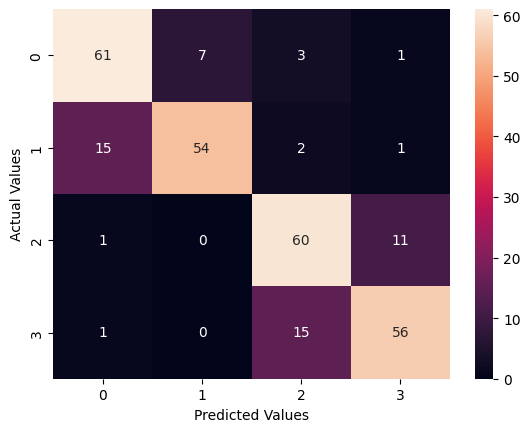

In [153]:
ufbcsp1 = UFBCSP(n_components=4, k=16, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp1.fit(a01_train, y_mi_a01_train)
ufbcsp1.score_report(a01_test, y_mi_a01_test)

### 6.1.2. Sujeto 2

Acc train: 86.11%
Acc test: 57.99%
Kappa score: 0.44


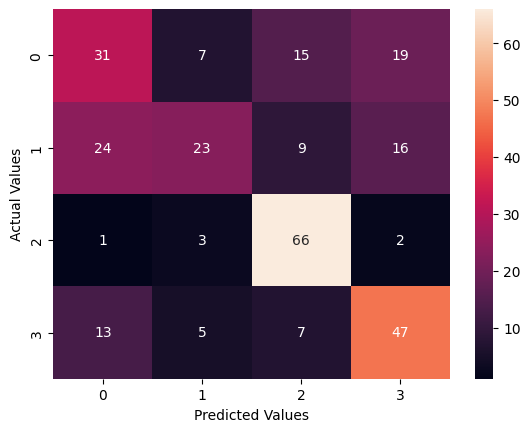

In [154]:
ufbcsp2 = UFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp2.fit(a02_train, y_mi_a02_train)
ufbcsp2.score_report(a02_test, y_mi_a02_test)

### 6.1.3. Sujeto 3

Acc train: 88.19%
Acc test: 86.11%
Kappa score: 0.81


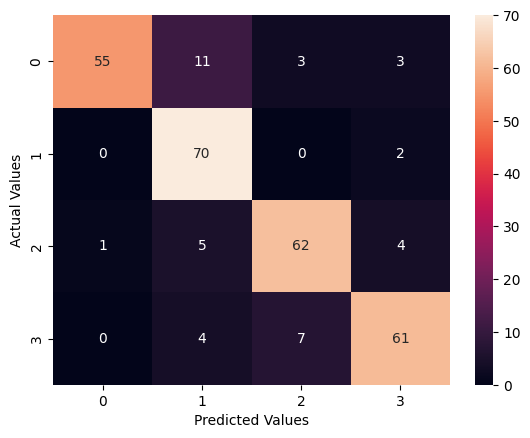

In [155]:
ufbcsp3 = UFBCSP(n_components=10, k=10, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp3.fit(a03_train, y_mi_a03_train)
ufbcsp3.score_report(a03_test, y_mi_a03_test)

### 6.1.4. Sujeto 4

Acc train: 100.00%
Acc test: 52.78%
Kappa score: 0.37


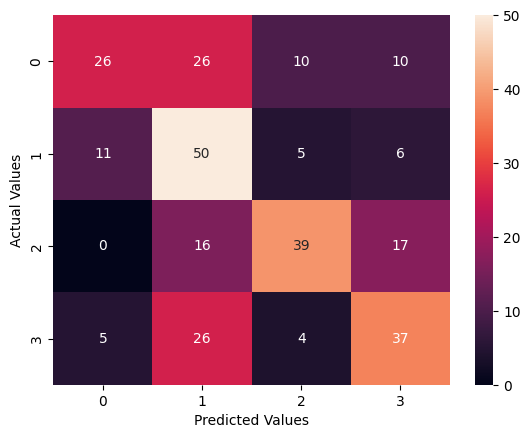

In [156]:
ufbcsp4 = UFBCSP(n_components=10, k=60, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp4.fit(a04_train, y_mi_a04_train)
ufbcsp4.score_report(a04_test, y_mi_a04_test)

### 6.1.5. Sujeto 5

Acc train: 88.19%
Acc test: 55.90%
Kappa score: 0.41


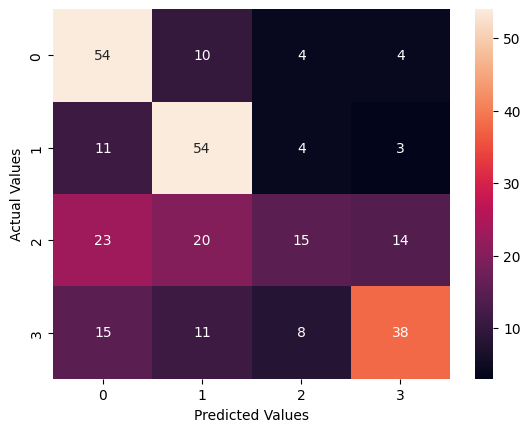

In [157]:
ufbcsp5 = UFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp5.fit(a05_train, y_mi_a05_train)
ufbcsp5.score_report(a05_test, y_mi_a05_test)

### 6.1.6. Sujeto 6

Acc train: 70.49%
Acc test: 46.53%
Kappa score: 0.29


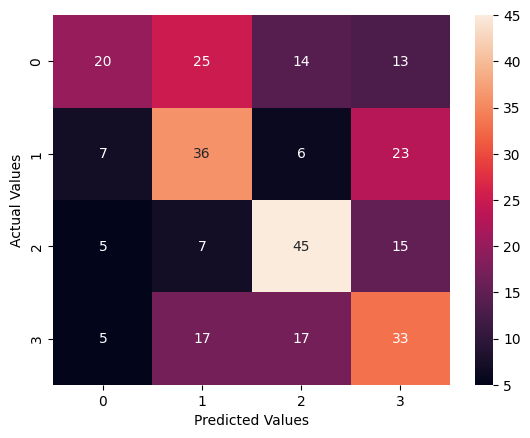

In [158]:
ufbcsp6 = UFBCSP(n_components=4, k=8, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp6.fit(a06_train, y_mi_a06_train)
ufbcsp6.score_report(a06_test, y_mi_a06_test)

### 6.1.7. Sujeto 7

Acc train: 99.31%
Acc test: 67.71%
Kappa score: 0.57


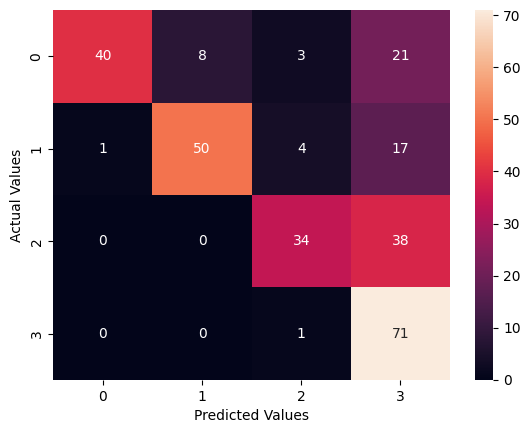

In [159]:
ufbcsp7 = UFBCSP(n_components=12, k=72, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp7.fit(a07_train, y_mi_a07_train)
ufbcsp7.score_report(a07_test, y_mi_a07_test)

### 6.1.8. Sujeto 8

Acc train: 96.88%
Acc test: 70.14%
Kappa score: 0.60


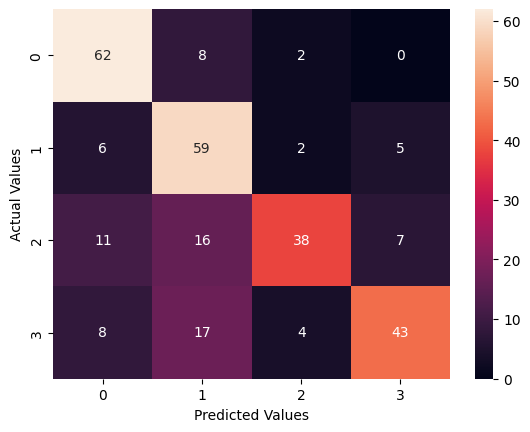

In [160]:
ufbcsp8 = UFBCSP(n_components=10, k=40, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp8.fit(a08_train, y_mi_a08_train)
ufbcsp8.score_report(a08_test, y_mi_a08_test)

### 6.1.9. Sujeto 9

Acc train: 93.75%
Acc test: 63.54%
Kappa score: 0.51


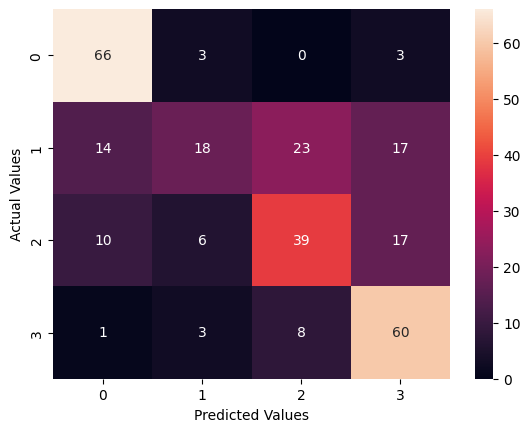

In [161]:
ufbcsp9 = UFBCSP(n_components=12, k=60, estimator=SVC(kernel="rbf", random_state=42))
ufbcsp9.fit(a09_train, y_mi_a09_train)
ufbcsp9.score_report(a09_test, y_mi_a09_test)

## 6.2. Brain Wave Filter Bank Common Spatial Pattern

### 6.2.1. Sujeto 1

Acc train: 87.15%
Acc test: 71.88%
Kappa score: 0.62


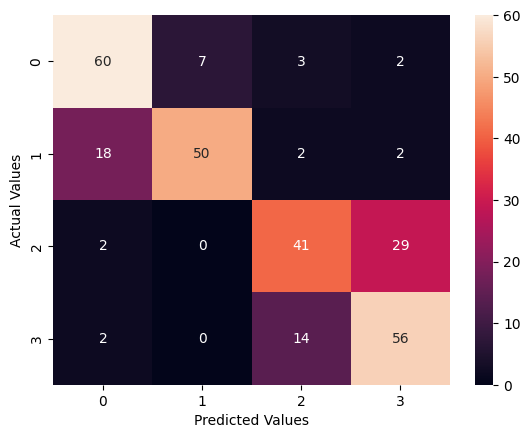

In [162]:
bwfbcsp1 = BWFBCSP(n_components=4, k=16, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp1.fit(a01_train, y_mi_a01_train)
bwfbcsp1.score_report(a01_test, y_mi_a01_test)

### 6.2.2. Sujeto 2

Acc train: 84.03%
Acc test: 49.65%
Kappa score: 0.33


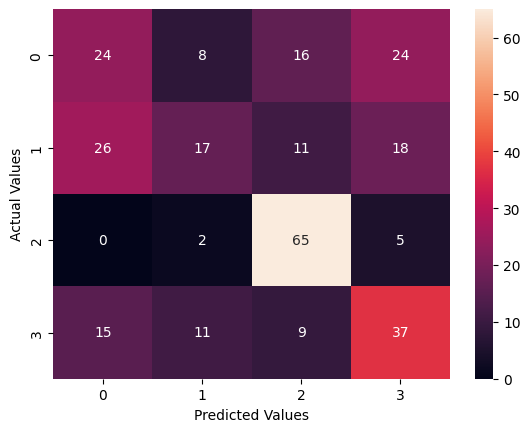

In [163]:
bwfbcsp2 = BWFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp2.fit(a02_train, y_mi_a02_train)
bwfbcsp2.score_report(a02_test, y_mi_a02_test)

### 6.2.3. Sujeto 3

Acc train: 83.68%
Acc test: 77.43%
Kappa score: 0.70


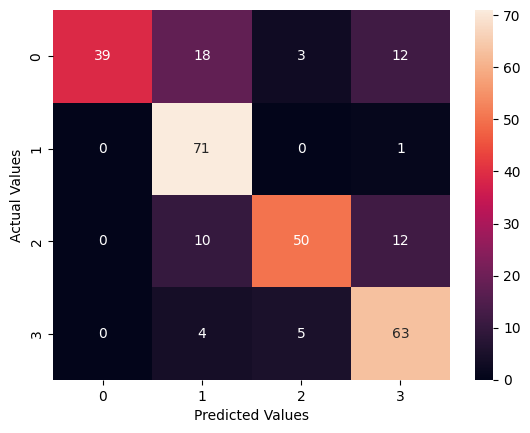

In [164]:
bwfbcsp3 = BWFBCSP(n_components=10, k=10, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp3.fit(a03_train, y_mi_a03_train)
bwfbcsp3.score_report(a03_test, y_mi_a03_test)

### 6.2.4. Sujeto 4

Acc train: 97.92%
Acc test: 39.93%
Kappa score: 0.20


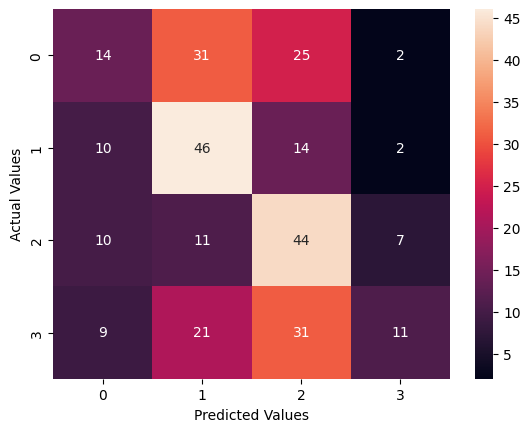

In [165]:
bwfbcsp4 = BWFBCSP(n_components=10, k=60, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp4.fit(a04_train, y_mi_a04_train)
bwfbcsp4.score_report(a04_test, y_mi_a04_test)

### 6.2.5. Sujeto 5

Acc train: 75.35%
Acc test: 35.07%
Kappa score: 0.13


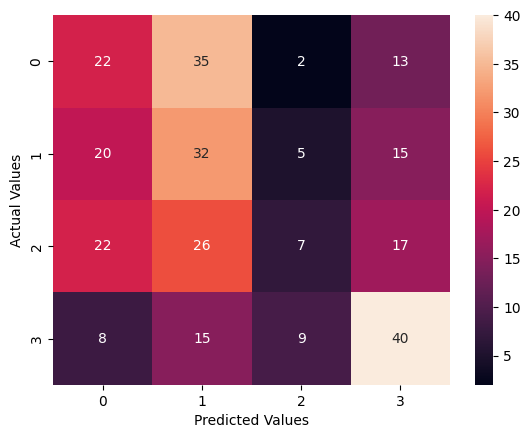

In [166]:
bwfbcsp5 = BWFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp5.fit(a05_train, y_mi_a05_train)
bwfbcsp5.score_report(a05_test, y_mi_a05_test)

### 6.2.6. Sujeto 6

Acc train: 64.24%
Acc test: 43.75%
Kappa score: 0.25


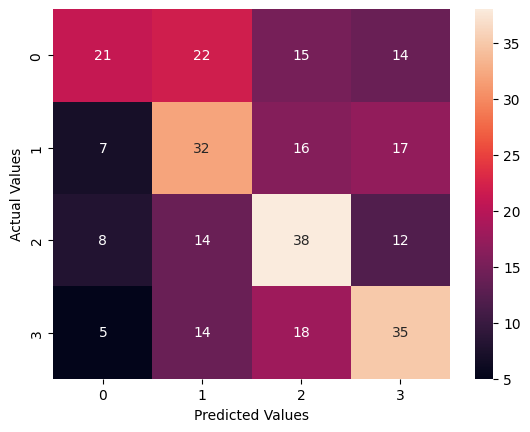

In [167]:
bwfbcsp6 = BWFBCSP(n_components=4, k=8, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp6.fit(a06_train, y_mi_a06_train)
bwfbcsp6.score_report(a06_test, y_mi_a06_test)

### 6.2.7. Sujeto 7

Acc train: 99.31%
Acc test: 61.46%
Kappa score: 0.49


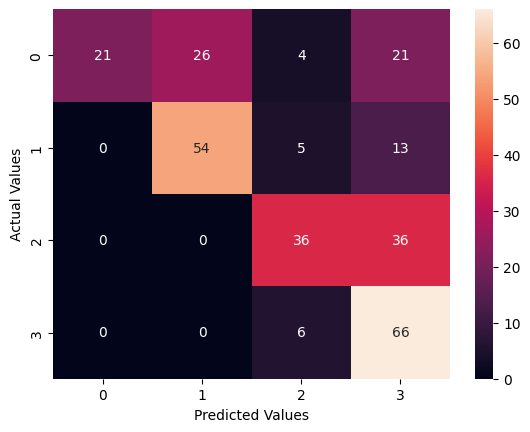

In [168]:
bwfbcsp7 = BWFBCSP(n_components=12, k=72, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp7.fit(a07_train, y_mi_a07_train)
bwfbcsp7.score_report(a07_test, y_mi_a07_test)

### 6.2.8. Sujeto 8

Acc train: 94.44%
Acc test: 69.79%
Kappa score: 0.60


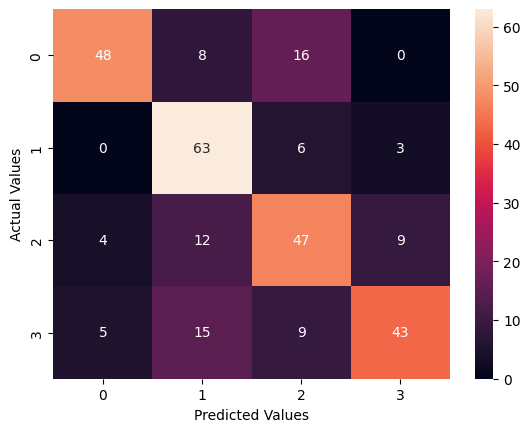

In [169]:
bwfbcsp8 = BWFBCSP(n_components=10, k=40, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp8.fit(a08_train, y_mi_a08_train)
bwfbcsp8.score_report(a08_test, y_mi_a08_test)

### 6.2.9. Sujeto 9

Acc train: 91.32%
Acc test: 60.07%
Kappa score: 0.47


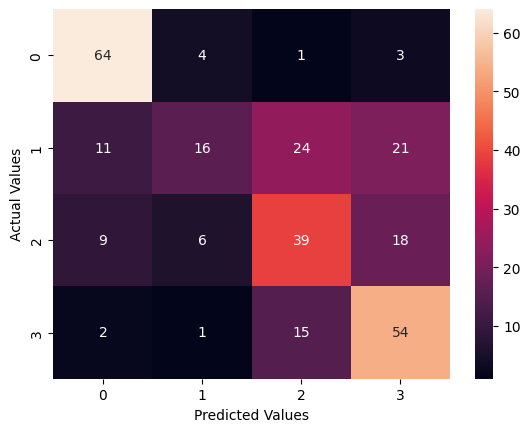

In [170]:
bwfbcsp9 = BWFBCSP(n_components=12, k=60, estimator=SVC(kernel="rbf", random_state=42))
bwfbcsp9.fit(a09_train, y_mi_a09_train)
bwfbcsp9.score_report(a09_test, y_mi_a09_test)

## 6.3. Uniform Differentiated Filter Bank Common Spatial Pattern

### 6.3.1. Sujeto 1

Acc train: 90.97%
Acc test: 79.51%
Kappa score: 0.73


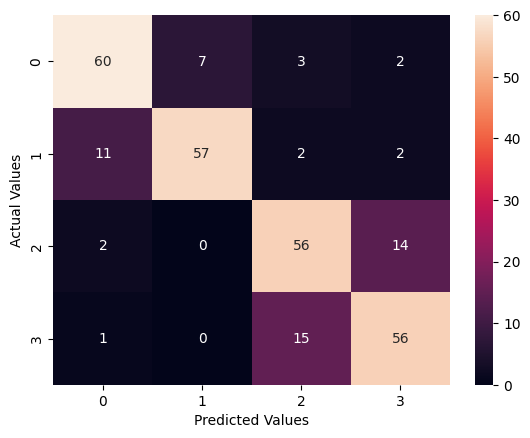

In [171]:
udfbcsp1 = UDFBCSP(n_components=4, k=16, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp1.fit(a01_train, y_mi_a01_train)
udfbcsp1.score_report(a01_test, y_mi_a01_test)

### 6.3.2. Sujeto 2

Acc train: 84.38%
Acc test: 51.74%
Kappa score: 0.36


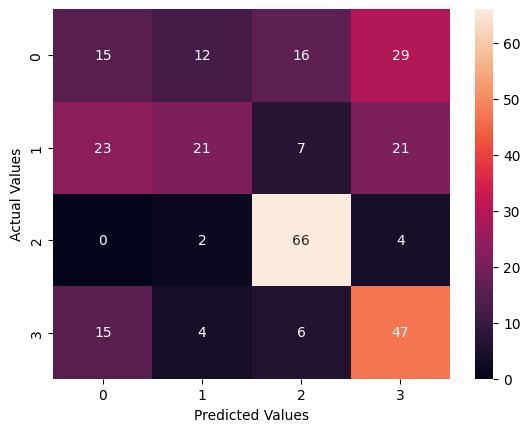

In [172]:
udfbcsp2 = UDFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp2.fit(a02_train, y_mi_a02_train)
udfbcsp2.score_report(a02_test, y_mi_a02_test)

### 6.3.3. Sujeto 3

Acc train: 88.54%
Acc test: 81.60%
Kappa score: 0.75


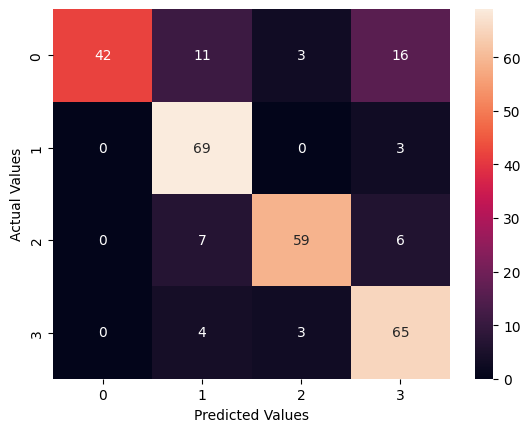

In [173]:
udfbcsp3 = UDFBCSP(n_components=10, k=10, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp3.fit(a03_train, y_mi_a03_train)
udfbcsp3.score_report(a03_test, y_mi_a03_test)

### 6.3.4. Sujeto 4

Acc train: 100.00%
Acc test: 47.22%
Kappa score: 0.30


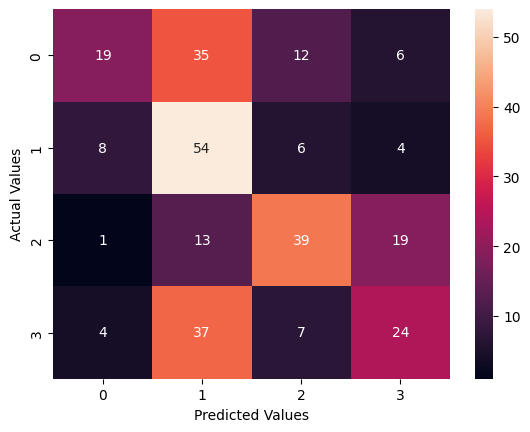

In [174]:
udfbcsp4 = UDFBCSP(n_components=10, k=60, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp4.fit(a04_train, y_mi_a04_train)
udfbcsp4.score_report(a04_test, y_mi_a04_test)

### 6.3.5. Sujeto 5

Acc train: 90.97%
Acc test: 52.43%
Kappa score: 0.37


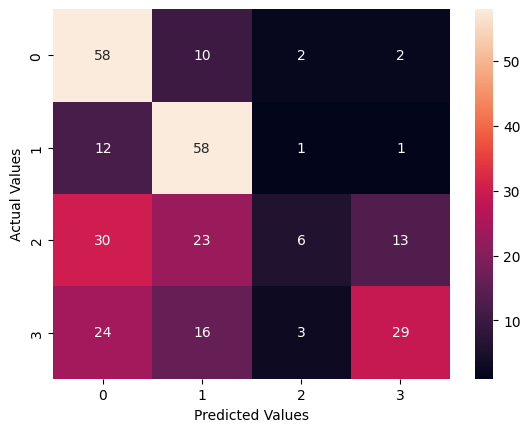

In [175]:
udfbcsp5 = UDFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp5.fit(a05_train, y_mi_a05_train)
udfbcsp5.score_report(a05_test, y_mi_a05_test)

### 6.3.6. Sujeto 6

Acc train: 71.18%
Acc test: 40.28%
Kappa score: 0.20


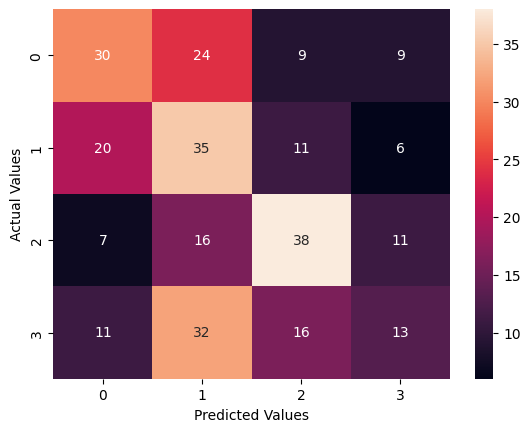

In [176]:
udfbcsp6 = UDFBCSP(n_components=4, k=8, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp6.fit(a06_train, y_mi_a06_train)
udfbcsp6.score_report(a06_test, y_mi_a06_test)

### 6.3.7. Sujeto 7

Acc train: 99.65%
Acc test: 70.49%
Kappa score: 0.61


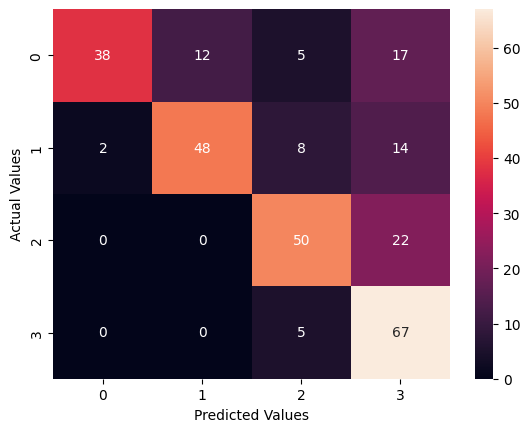

In [177]:
udfbcsp7 = UDFBCSP(n_components=12, k=72, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp7.fit(a07_train, y_mi_a07_train)
udfbcsp7.score_report(a07_test, y_mi_a07_test)

### 6.3.8. Sujeto 8

Acc train: 96.88%
Acc test: 69.79%
Kappa score: 0.60


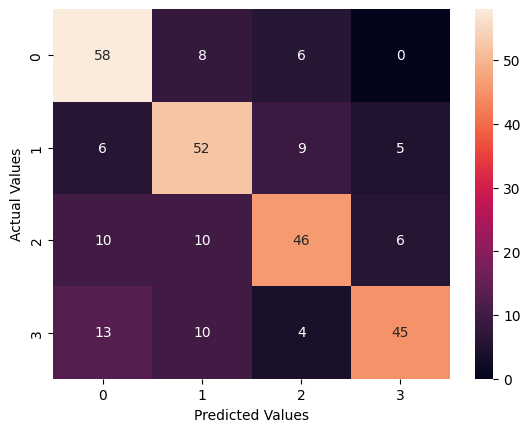

In [178]:
udfbcsp8 = UDFBCSP(n_components=10, k=40, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp8.fit(a08_train, y_mi_a08_train)
udfbcsp8.score_report(a08_test, y_mi_a08_test)

### 6.3.9. Sujeto 9

Acc train: 93.06%
Acc test: 62.15%
Kappa score: 0.50


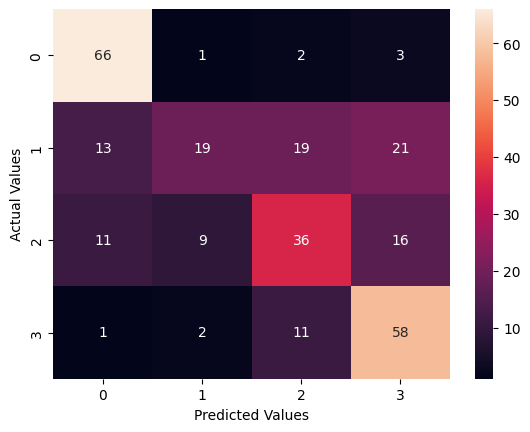

In [179]:
udfbcsp9 = UDFBCSP(n_components=12, k=60, estimator=SVC(kernel="rbf", random_state=42))
udfbcsp9.fit(a09_train, y_mi_a09_train)
udfbcsp9.score_report(a09_test, y_mi_a09_test)

# BWDFBCSP

### 6.4.1. Sujeto 1

Acc train: 85.42%
Acc test: 78.12%
Kappa score: 0.71


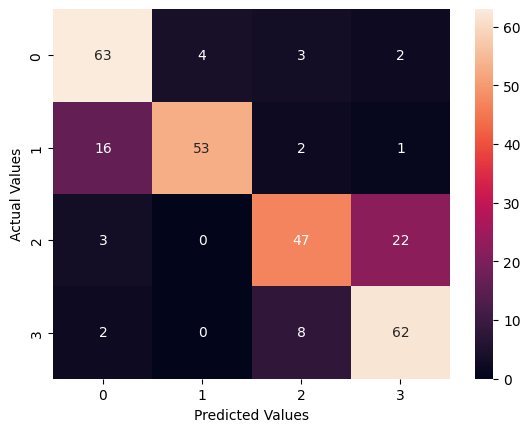

In [180]:
bwdfbcsp1 = BWDFBCSP(n_components=4, k=16, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp1.fit(a01_train, y_mi_a01_train)
bwdfbcsp1.score_report(a01_test, y_mi_a01_test)

### 6.4.2. Sujeto 2

Acc train: 81.94%
Acc test: 47.57%
Kappa score: 0.30


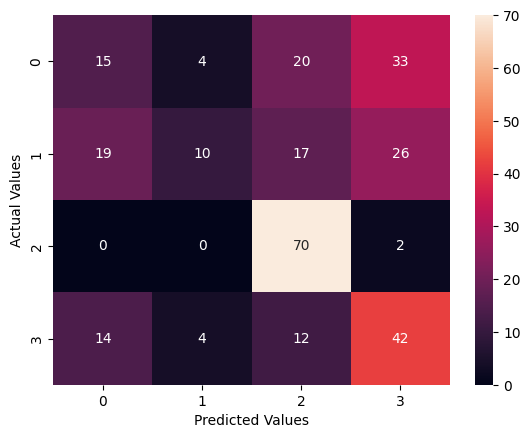

In [181]:
bwdfbcsp2 = BWDFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp2.fit(a02_train, y_mi_a02_train)
bwdfbcsp2.score_report(a02_test, y_mi_a02_test)

### 6.4.3. Sujeto 3

Acc train: 77.78%
Acc test: 64.24%
Kappa score: 0.52


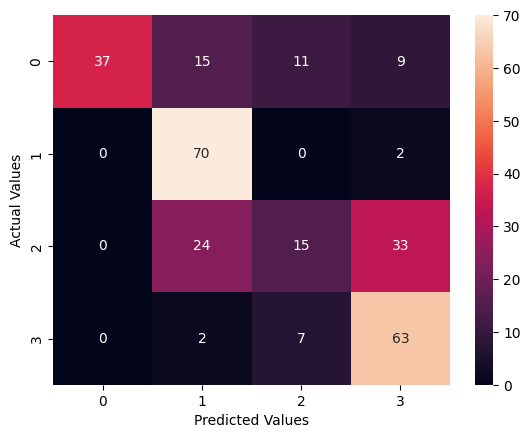

In [182]:
bwdfbcsp3 = BWDFBCSP(n_components=10, k=10, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp3.fit(a03_train, y_mi_a03_train)
bwdfbcsp3.score_report(a03_test, y_mi_a03_test)

### 6.4.4. Sujeto 4

Acc train: 98.96%
Acc test: 42.01%
Kappa score: 0.23


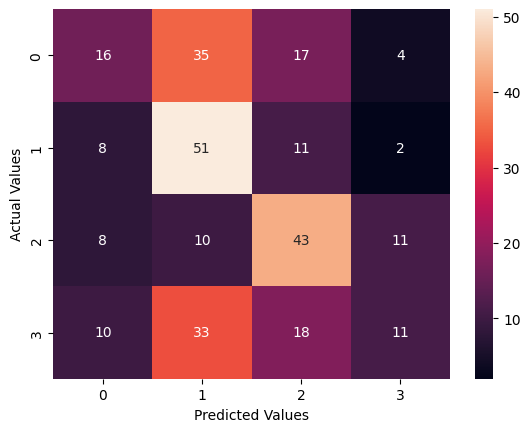

In [183]:
bwdfbcsp4 = BWDFBCSP(n_components=10, k=60, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp4.fit(a04_train, y_mi_a04_train)
bwdfbcsp4.score_report(a04_test, y_mi_a04_test)

### 6.4.5. Sujeto 5

Acc train: 75.69%
Acc test: 33.33%
Kappa score: 0.11


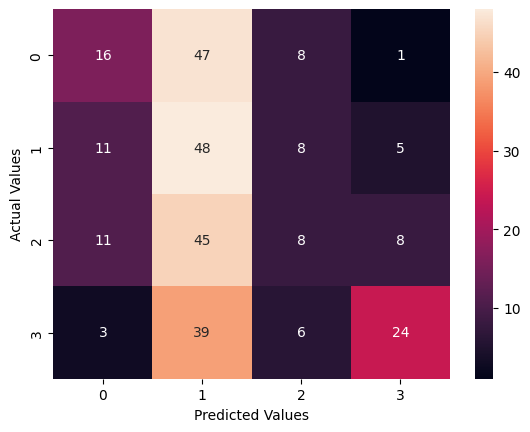

In [184]:
bwdfbcsp5 = BWDFBCSP(n_components=2, k=12, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp5.fit(a05_train, y_mi_a05_train)
bwdfbcsp5.score_report(a05_test, y_mi_a05_test)

### 6.4.6. Sujeto 6

Acc train: 64.93%
Acc test: 36.46%
Kappa score: 0.15


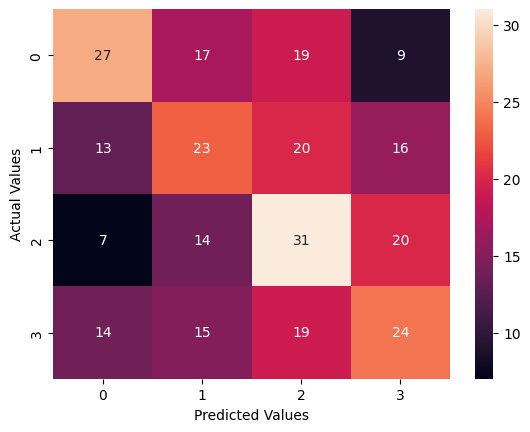

In [185]:
bwdfbcsp6 = BWDFBCSP(n_components=4, k=8, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp6.fit(a06_train, y_mi_a06_train)
bwdfbcsp6.score_report(a06_test, y_mi_a06_test)

### 6.4.7. Sujeto 7

Acc train: 98.96%
Acc test: 61.11%
Kappa score: 0.48


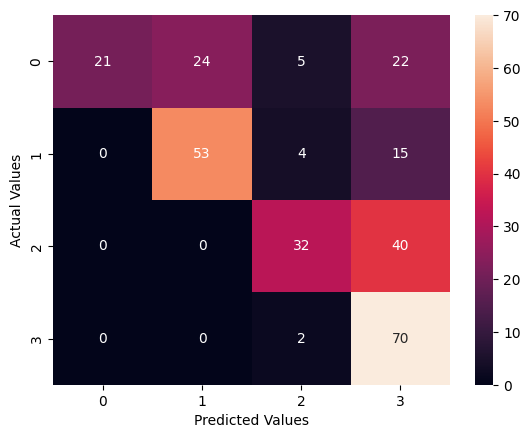

In [186]:
bwdfbcsp7 = BWDFBCSP(n_components=12, k=72, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp7.fit(a07_train, y_mi_a07_train)
bwdfbcsp7.score_report(a07_test, y_mi_a07_test)

### 6.4.8. Sujeto 8

Acc train: 95.49%
Acc test: 67.71%
Kappa score: 0.57


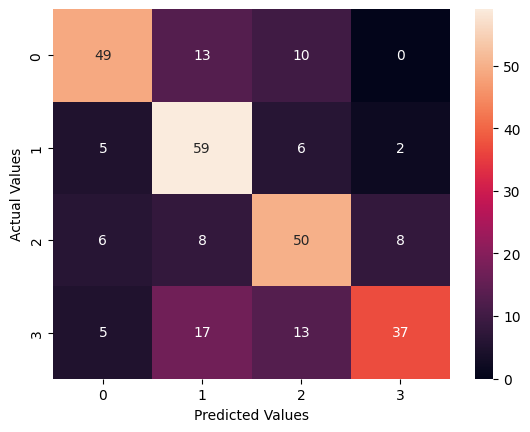

In [187]:
bwdfbcsp8 = BWDFBCSP(n_components=10, k=40, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp8.fit(a08_train, y_mi_a08_train)
bwdfbcsp8.score_report(a08_test, y_mi_a08_test)

### 6.4.9. Sujeto 9

Acc train: 93.75%
Acc test: 62.15%
Kappa score: 0.50


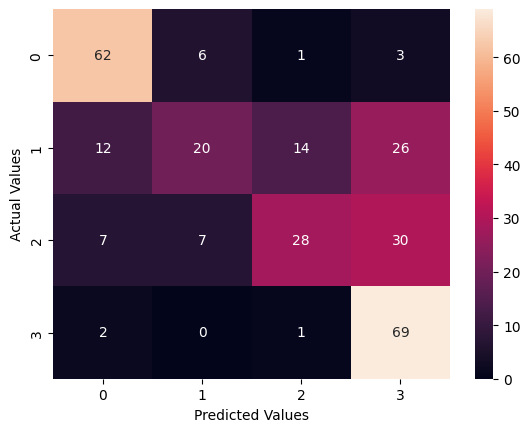

In [188]:
bwdfbcsp9 = BWDFBCSP(n_components=12, k=60, estimator=SVC(kernel="rbf", random_state=42))
bwdfbcsp9.fit(a09_train, y_mi_a09_train)
bwdfbcsp9.score_report(a09_test, y_mi_a09_test)